In [144]:
import json
import pandas as pd
import gspread
from google.colab import userdata

# 1) Autenticación con tu secreto MI_JSON (service account)
mi_json = userdata.get("MI_JSON")
creds_dict = json.loads(mi_json)
gc = gspread.service_account_from_dict(creds_dict)

# 2) Definir llaves y gids
key_mora = "1jcPPhtF2YK3Kr7P_A0Mgh2OqhOfnVWB2to3UPoSH5tE"
gid_mora = 916870612

key_cc = "1xGSzneJkRqREZupLshG9jaNK8wbP8WpV-yjUs_Lm7AA"
gid_cc = 1534851414

# 3) Abrir por key y obtener worksheet por GID
ss_mora = gc.open_by_key(key_mora)
ws_mora = ss_mora.get_worksheet_by_id(gid_mora)

ss_cc = gc.open_by_key(key_cc)
ws_cc = ss_cc.get_worksheet_by_id(gid_cc)

# 4) Convertir a DataFrame (usando la primera fila como encabezados)
vals_mora = ws_mora.get_all_values()
vals_cc = ws_cc.get_all_values()

# Manejo por si la hoja está vacía
if not vals_mora:
    df_mora = pd.DataFrame()
else:
    df_mora = pd.DataFrame(vals_mora[1:], columns=vals_mora[0])

if not vals_cc:
    df_cc = pd.DataFrame()
else:
    df_cc = pd.DataFrame(vals_cc[1:], columns=vals_cc[0])

print("df_mora:", df_mora.shape)
print("df_cc:", df_cc.shape)
df_mora.head(), df_cc.head()

df_mora: (81484, 16)
df_cc: (24853, 31)


(   REFERENCIA               FECHA X_COBRAR    PAGO X_COBRAR_FUTURO  \
 0  1000185400  2025-06-30 0:00:00    19406   89994           70588   
 1  1000185400  2025-07-31 0:00:00    70588                           
 2  1000185400  2025-08-31 0:00:00                                    
 3  1000591190  2025-09-30 0:00:00    63866  343010           64779   
 4  1000591190  2025-10-28 0:00:00    64779                           
 
   PLAN_PAGADO PLAN_PAGADO_INCOBRABLE        FECHA_ORIGEN         FECHA_COBRO  \
 0      -70588                 -70588  2025-06-19 0:00:00  2025-06-20 0:00:00   
 1                                                                              
 2                                                                              
 3     -622069                -622069  2025-09-11 0:00:00  2025-09-15 0:00:00   
 4     -557290                -557290                                           
 
                  RESPONSABLE       FECHA_DE_PAGO MOROSO DIAS_EN_MORA  \
 0   Hector

In [145]:
import pandas as pd
from dateutil.relativedelta import relativedelta

# ------------ 1) Normalizar fechas (soporta strings y seriales de Excel) ------------
def to_datetime_robusto(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().replace({"": pd.NA, "NaT": pd.NA, "None": pd.NA})
    dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    m_num = dt.isna() & s.str.fullmatch(r"\d+")
    if m_num.any():
        serial = s[m_num].astype(float)
        dt.loc[m_num] = pd.to_datetime("1899-12-30") + pd.to_timedelta(serial, unit="D")
    return dt


# ------------ 2) Cálculo automático de la ventana mensual con rezago 6 meses ------------
def calcular_ventana_rezagada(tz="America/Bogota"):
    hoy = pd.Timestamp.now(tz=tz)
    # Calculamos cuántos meses han pasado desde octubre 2025
    base = pd.Timestamp(2025, 10, 1, tz=tz)  # mes base del patrón
    diff_meses = (hoy.year - base.year) * 12 + (hoy.month - base.month)

    # A partir del patrón base (ene 2024 a abr 2025), sumamos diff_meses meses a ambos extremos
    ini_base = pd.Timestamp(2024, 1, 1)
    fin_base = pd.Timestamp(2025, 4, 30)
    ini = ini_base + relativedelta(months=+diff_meses)
    fin = fin_base + relativedelta(months=+diff_meses)

    return ini, fin


# ------------ 3) Aplicar ventana dinámica ------------
ini, fin = calcular_ventana_rezagada()
print(f"Ventana activa automática: {ini.date()} → {fin.date()}")

# ------------ 4) Normalización de fechas en df_mora ------------
df_mora = df_mora.copy()
df_mora["FECHA_ORIGEN"] = to_datetime_robusto(df_mora["FECHA_ORIGEN"])
df_mora["FECHA"]        = to_datetime_robusto(df_mora["FECHA"])

# ------------ 5) Todas las FECHA_ORIGEN válidas dentro del rango por referencia ------------
origenes_validos = (
    df_mora[["REFERENCIA", "FECHA_ORIGEN"]]
      .dropna(subset=["FECHA_ORIGEN"])
)

origenes_validos = origenes_validos.assign(
    ORIGEN_EN_VENTANA = origenes_validos["FECHA_ORIGEN"].between(ini, fin, inclusive="both")
)

origen_min_por_ref = (
    origenes_validos.loc[origenes_validos["ORIGEN_EN_VENTANA"]]
    .groupby("REFERENCIA")["FECHA_ORIGEN"]
    .min()
    .rename("ORIGEN_MIN_EN_VENTANA")
)

# ------------ 6) Anexar a df_mora y filtrar ------------
df_mora = df_mora.merge(origen_min_por_ref, on="REFERENCIA", how="left")
mask_ref_tiene_origen_en_ventana = df_mora["ORIGEN_MIN_EN_VENTANA"].notna()
mask_fecha_desde_min_origen      = df_mora["FECHA"] >= df_mora["ORIGEN_MIN_EN_VENTANA"]
df_filtrado = df_mora[mask_ref_tiene_origen_en_ventana & mask_fecha_desde_min_origen].copy()

# ------------ 7) Marcar filas que son exactamente una FECHA_ORIGEN ------------
df_filtrado["ES_FECHA_ORIGEN"] = (df_filtrado["FECHA"] == df_filtrado["FECHA_ORIGEN"])

# ------------ 8) Orden y resumen ------------
df_filtrado.sort_values(["REFERENCIA", "FECHA"], inplace=True)
print(
    "Refs totales:", df_mora["REFERENCIA"].nunique(),
    "→ Refs con FECHA_ORIGEN en ventana:", df_filtrado["REFERENCIA"].nunique(),
    "→ Filas resultantes:", len(df_filtrado)
)

Ventana activa automática: 2024-01-01 → 2025-04-30


/tmp/ipython-input-3308039045.py:7: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/tmp/ipython-input-3308039045.py:7: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



Refs totales: 8104 → Refs con FECHA_ORIGEN en ventana: 3743 → Filas resultantes: 28507


In [146]:
df_filtrado

,REFERENCIA,FECHA,X_COBRAR,PAGO,X_COBRAR_FUTURO,PLAN_PAGADO,PLAN_PAGADO_INCOBRABLE,FECHA_ORIGEN,FECHA_COBRO,RESPONSABLE,FECHA_DE_PAGO,MOROSO,DIAS_EN_MORA,MORA_STATUS,Saldo actual,PAGO_PARCIAL,ORIGEN_MIN_EN_VENTANA,ES_FECHA_ORIGEN
9,1001082965,2024-11-30,588235,689780,579404,-101545,-101545,2024-11-18,2024-11-20 0:00:00,Daniel Alejandro Umbarila Bolaños,2024-11-18 0:00:00,FALSE,0,Al día,,0,2024-11-18,False
10,1001082965,2024-12-31,579404,477860,1647020,-1,-1,2024-12-23,2024-12-27 0:00:00,Alba Yohana Moreno Martin,2024-12-23 0:00:00,FALSE,0,Al día,,0,2024-11-18,False
11,1001082965,2025-01-31,,,1647020,-1,-1,2025-01-31,,Maria Alejandra Bejarano Tumay,,FALSE,0,Al día,,0,2024-11-18,True
12,1001082965,2025-02-28,505042,624732,1141978,-119690,-119690,NaT,2025-02-10 0:00:00,Maria Alejandra Bejarano Tumay,2025-02-03 0:00:00,FALSE,0,Al día,,0,2024-11-18,False
13,1001082965,2025-03-31,,,1141978,-119690,-119690,NaT,,Maria Alejandra Bejarano Tumay,,FALSE,0,Al día,,0,2024-11-18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81471,98702966,2025-09-30,868067,,7912853,1340086,1340086,NaT,,Jana Milena Lopez Buitrago,2025-09-15 0:00:00,TRUE,46,Mora 30,,0,2024-08-27,False
81472,98702966,2025-10-28,868067,,7044786,2208153,2208153,NaT,,Jana Milena Lopez Buitrago,2025-10-15 0:00:00,TRUE,74,Mora 60,,0,2024-08-27,False
81481,9957452,2024-08-31,619328,798525,179197,-179197,-179197,2024-08-13,2024-08-14 0:00:00,Juan Felipe Hurtado Mercado,2024-08-13 0:00:00,FALSE,0,Al día,,0,2024-08-13,False
81482,9957452,2024-09-30,179197,,,,,NaT,,Juan Felipe Hurtado Mercado,2024-09-05 0:00:00,FALSE,0,Cerrado,,0,2024-08-13,False


In [147]:
df_mora = df_filtrado.copy()

In [148]:
import pandas as pd
import numpy as np

# --- Ventana de fechas plausibles (ajústala si necesitas más rango) ---
MIN_DATE = pd.Timestamp('1900-01-01')
MAX_DATE = pd.Timestamp('2100-12-31')

def clamp_dates(s: pd.Series) -> pd.Series:
    """Pone NaT a fechas fuera de [MIN_DATE, MAX_DATE]."""
    s_out = s.copy()
    mask_bad = (s_out.notna()) & ((s_out < MIN_DATE) | (s_out > MAX_DATE))
    s_out[mask_bad] = pd.NaT
    return s_out

def to_datetime_flexible(s: pd.Series) -> pd.Series:
    """
    Convierte una serie a datetime manejando:
      - Seriales de Excel (días desde 1899-12-30) dentro de un rango razonable.
      - Epoch en segundos (~1e9) y milisegundos (~1e12).
      - Cadenas en formatos mixtos (dayfirst=True).
    Cualquier valor fuera de rango se convierte en NaT.
    """
    s = s.copy()

    # Normalizar strings y vacíos
    if s.dtype == object:
        s = s.astype(str).str.strip()
        s = s.replace({'': np.nan, 'NaT': np.nan, 'nat': np.nan, 'None': np.nan})

    # Intentar convertir a numérico donde aplique (sin forzar)
    num = pd.to_numeric(s, errors='coerce')

    out = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')

    # --- 1) Epoch en milisegundos (rango aprox ~2001–2033 si ~1e12 a ~2e12) ---
    # Permitimos rango más amplio pero razonable para evitar falsos positivos.
    mask_ms = num.between(5e11, 2e13, inclusive='left')  # 1970-01-01 +/- larga ventana
    if mask_ms.any():
        dt_ms = pd.to_datetime(num[mask_ms], unit='ms', origin='unix', errors='coerce')
        out.loc[mask_ms] = dt_ms

    # --- 2) Epoch en segundos (~1e9 a ~2e9) ---
    mask_s = num.between(5e8, 2e10, inclusive='left') & out.isna()
    if mask_s.any():
        dt_s = pd.to_datetime(num[mask_s], unit='s', origin='unix', errors='coerce')
        out.loc[mask_s] = dt_s

    # --- 3) Seriales de Excel (días) ---
    # Usamos un rango razonable: 1..80000 días ≈ 1900–~2120; lo recortamos luego a [1900,2100]
    mask_excel = num.between(1, 80000, inclusive='both') & out.isna()
    if mask_excel.any():
        # Base Excel Windows: 1899-12-30
        base = pd.Timestamp('1899-12-30')
        dt_xl = base + pd.to_timedelta(num[mask_excel].astype('float64'), unit='D')
        out.loc[mask_excel] = dt_xl

    # --- 4) Cadenas restantes (formatos mixtos + dayfirst) ---
    rest = out.isna()
    if rest.any():
        try:
            out.loc[rest] = pd.to_datetime(s[rest], format='mixed', dayfirst=True, errors='coerce')
        except TypeError:
            # Para pandas < 2.0 sin format='mixed'
            out.loc[rest] = pd.to_datetime(s[rest], dayfirst=True, errors='coerce')

    # --- 5) Recortar fechas fuera de rango ---
    out = clamp_dates(out)

    # --- 6) Normalizar a fecha (quitar hora) ---
    out = out.dt.normalize()

    return out

# --- 1) Convertir fechas en ambos DataFrames de forma robusta ---
df_mora['FECHA_ORIGEN'] = to_datetime_flexible(df_mora['FECHA_ORIGEN'])
df_cc['Originado']      = to_datetime_flexible(df_cc['Originado'])

# --- 2) (Opcional) Revisa si quedaron NaT para depurar posibles errores de origen ---
# print("NaT en df_mora['FECHA_ORIGEN']:", df_mora['FECHA_ORIGEN'].isna().sum())
# print("NaT en df_cc['Originado']:", df_cc['Originado'].isna().sum())

# --- 3) Columnas necesarias de df_cc ---
cols_cc = ['Referencia', 'Originado', 'BANCO', 'amount_promedio', 'amount_total',
           'n_pagos', 'PaB_total', 'n_pagos_PaB', 'Pri-ult', 'C/A']
faltantes = [c for c in cols_cc if c not in df_cc.columns]
if faltantes:
    raise KeyError(f"Faltan columnas en df_cc para el merge: {faltantes}")

# --- 4) Merge por REFERENCIA/FECHA_ORIGEN vs Referencia/Originado ---
df_mora = df_mora.merge(
    df_cc[cols_cc],
    left_on=['REFERENCIA', 'FECHA_ORIGEN'],
    right_on=['Referencia', 'Originado'],
    how='left'  # usa 'inner' si quieres solo coincidencias exactas
)

# --- 5) Limpiar llaves duplicadas ---
df_mora.drop(columns=['Referencia', 'Originado'], inplace=True)

# --- 6) (Opcional) Diagnóstico de emparejamientos ---
# from collections import Counter
# print("Conteo de matches:", Counter(
#     df_mora.merge(
#         df_cc[['Referencia','Originado']].drop_duplicates(),
#         left_on=['REFERENCIA','FECHA_ORIGEN'],
#         right_on=['Referencia','Originado'],
#         how='left', indicator=True
#     )['_merge']
# ))

In [149]:
df_mora.drop_duplicates(inplace=True)

In [150]:
df_mora

,REFERENCIA,FECHA,X_COBRAR,PAGO,X_COBRAR_FUTURO,PLAN_PAGADO,PLAN_PAGADO_INCOBRABLE,FECHA_ORIGEN,FECHA_COBRO,RESPONSABLE,...,ORIGEN_MIN_EN_VENTANA,ES_FECHA_ORIGEN,BANCO,amount_promedio,amount_total,n_pagos,PaB_total,n_pagos_PaB,Pri-ult,C/A
0,1001082965,2024-11-30,588235,689780,579404,-101545,-101545,2024-11-18,2024-11-20 0:00:00,Daniel Alejandro Umbarila Bolaños,...,2024-11-18,False,Compensar,410419,820838,2,1390000,1,2,0.04922800754
1,1001082965,2024-12-31,579404,477860,1647020,-1,-1,2024-12-23,2024-12-27 0:00:00,Alba Yohana Moreno Martin,...,2024-11-18,False,Bancolombia,189551,568653,3,590000,3,1,0
2,1001082965,2025-01-31,,,1647020,-1,-1,2025-01-31,,Maria Alejandra Bejarano Tumay,...,2024-11-18,True,Bancolombia,979977,1959954,2,10928000,4,5,1.005446711
4,1001082965,2025-02-28,505042,624732,1141978,-119690,-119690,NaT,2025-02-10 0:00:00,Maria Alejandra Bejarano Tumay,...,2024-11-18,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1001082965,2025-03-31,,,1141978,-119690,-119690,NaT,,Maria Alejandra Bejarano Tumay,...,2024-11-18,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36692,98702966,2025-09-30,868067,,7912853,1340086,1340086,NaT,,Jana Milena Lopez Buitrago,...,2024-08-27,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36693,98702966,2025-10-28,868067,,7044786,2208153,2208153,NaT,,Jana Milena Lopez Buitrago,...,2024-08-27,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36694,9957452,2024-08-31,619328,798525,179197,-179197,-179197,2024-08-13,2024-08-14 0:00:00,Juan Felipe Hurtado Mercado,...,2024-08-13,False,Bancolombia,475122.5,950245,2,2800000,1,2,0.4725183186
36695,9957452,2024-09-30,179197,,,,,NaT,,Juan Felipe Hurtado Mercado,...,2024-08-13,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
import pandas as pd
import numpy as np

# 1) (Opcional) Normalizar nombres
df_mora.columns = (
    df_mora.columns.astype(str)
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^\w/.-]", "", regex=True)
    .str.upper()
)

# 2) Convertir FECHA a datetime
df_mora["FECHA"] = pd.to_datetime(df_mora["FECHA"], errors="coerce")

# 3) Convertir FECHA_ORIGEN de forma robusta (puede venir como str/int ns/ms/s)
feo_raw = df_mora["FECHA_ORIGEN"]
feo_try = pd.to_datetime(feo_raw, errors="coerce")

mask_num = pd.to_numeric(feo_raw, errors="coerce").notna() & feo_try.isna()
if mask_num.any():
    vals = pd.to_numeric(feo_raw[mask_num], errors="coerce").astype("int64").abs()
    med = vals.median()
    if med > 1e17:       # ns
        feo_try.loc[mask_num] = pd.to_datetime(feo_raw[mask_num], unit="ns", errors="coerce")
    elif med > 1e14:     # us
        feo_try.loc[mask_num] = pd.to_datetime(feo_raw[mask_num], unit="us", errors="coerce")
    elif med > 1e11:     # ms
        feo_try.loc[mask_num] = pd.to_datetime(feo_raw[mask_num], unit="ms", errors="coerce")
    else:                # s
        feo_try.loc[mask_num] = pd.to_datetime(feo_raw[mask_num], unit="s", errors="coerce")

df_mora["FECHA_ORIGEN"] = feo_try.dt.normalize()

# 4) Orden lógico para propagar por tiempo, guardando el orden original
df_mora["_ORD_"] = np.arange(len(df_mora))
df_mora = df_mora.sort_values(["REFERENCIA", "FECHA"], kind="mergesort")

# 5) Rellenar SOLO los NaT con el último hito dentro de la misma referencia
df_mora["FECHA_ORIGEN"] = (
    df_mora.groupby("REFERENCIA", sort=False)["FECHA_ORIGEN"].ffill()
)

# 6) Restaurar orden original
df_mora = df_mora.sort_values("_ORD_", kind="mergesort").drop(columns="_ORD_")

# (Opcional) Verificación
print("dtype FECHA_ORIGEN:", df_mora["FECHA_ORIGEN"].dtype)

dtype FECHA_ORIGEN: datetime64[ns]


In [152]:
# 3) Convertir fechas: excluye FECHA_ORIGEN del loop masivo
fechas_cols = [c for c in df_mora.columns if "FECHA" in c.upper() and c.upper() != "FECHA_ORIGEN"]
for c in fechas_cols:
    df_mora[c + "_RAW"] = df_mora[c]
    df_mora[c] = pd.to_datetime(df_mora[c], errors="coerce")

# Si necesitas asegurar FECHA_ORIGEN como datetime sin tocar los valores:
df_mora["FECHA_ORIGEN"] = pd.to_datetime(df_mora["FECHA_ORIGEN"], errors="coerce")

# 4) Numéricas: evita columnas no numéricas
num_cols = ["AMOUNT_PROMEDIO", "AMOUNT_TOTAL", "N_PAGOS", "PAB_TOTAL", "N_PAGOS_PAB", "X_COBRAR"]
for c in num_cols:
    if c in df_mora.columns:
        df_mora[c + "_RAW"] = df_mora[c]
        df_mora[c] = pd.to_numeric(df_mora[c], errors="coerce")

# 6) ⚠️ NO recalcules FECHA_ORIGEN con min(); solo rellena NaT respetando hitos existentes
# (Asumiendo que ya aplicaste el ffill correcto en el paso anterior del pipeline)
# >>> elimina por completo esta línea que daña:
# df_mora["FECHA_ORIGEN"] = df_mora.groupby("REFERENCIA")["FECHA"].transform("min")

In [153]:
import pandas as pd

# Aseguramos que la columna de fecha esté en formato datetime
df_mora['FECHA'] = pd.to_datetime(df_mora['FECHA'])

# Identificar el primer X_COBRAR por combinación de REFERENCIA y FECHA_ORIGEN
pp_comision = (
    df_mora.sort_values(['REFERENCIA', 'FECHA_ORIGEN', 'FECHA'])
    .groupby(['REFERENCIA', 'FECHA_ORIGEN'], as_index=False)
    .first()[['REFERENCIA', 'FECHA_ORIGEN', 'X_COBRAR']]
    .rename(columns={'X_COBRAR': 'PP_Comision'})
)

# Unir la información al DataFrame original
df_mora = df_mora.merge(pp_comision, on=['REFERENCIA', 'FECHA_ORIGEN'], how='left')

In [154]:
df_mora

,REFERENCIA,FECHA,X_COBRAR,PAGO,X_COBRAR_FUTURO,PLAN_PAGADO,PLAN_PAGADO_INCOBRABLE,FECHA_ORIGEN,FECHA_COBRO,RESPONSABLE,...,FECHA_COBRO_RAW,FECHA_DE_PAGO_RAW,ES_FECHA_ORIGEN_RAW,AMOUNT_PROMEDIO_RAW,AMOUNT_TOTAL_RAW,N_PAGOS_RAW,PAB_TOTAL_RAW,N_PAGOS_PAB_RAW,X_COBRAR_RAW,PP_Comision
0,1001082965,2024-11-30,588235.0,689780,579404,-101545,-101545,2024-11-18,2024-11-20,Daniel Alejandro Umbarila Bolaños,...,2024-11-20 0:00:00,2024-11-18 0:00:00,False,410419,820838,2,1390000,1,588235,588235.0
1,1001082965,2024-12-31,579404.0,477860,1647020,-1,-1,2024-12-23,2024-12-27,Alba Yohana Moreno Martin,...,2024-12-27 0:00:00,2024-12-23 0:00:00,False,189551,568653,3,590000,3,579404,579404.0
2,1001082965,2025-01-31,NaN,,1647020,-1,-1,2025-01-31,NaT,Maria Alejandra Bejarano Tumay,...,,,True,979977,1959954,2,10928000,4,,505042.0
3,1001082965,2025-02-28,505042.0,624732,1141978,-119690,-119690,2025-01-31,2025-02-10,Maria Alejandra Bejarano Tumay,...,2025-02-10 0:00:00,2025-02-03 0:00:00,False,NaN,NaN,NaN,NaN,NaN,505042,505042.0
4,1001082965,2025-03-31,NaN,,1141978,-119690,-119690,2025-01-31,NaT,Maria Alejandra Bejarano Tumay,...,,,False,NaN,NaN,NaN,NaN,NaN,,505042.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,98702966,2025-09-30,868067.0,,7912853,1340086,1340086,2025-01-30,NaT,Jana Milena Lopez Buitrago,...,,2025-09-15 0:00:00,False,NaN,NaN,NaN,NaN,NaN,868067,1347899.0
28503,98702966,2025-10-28,868067.0,,7044786,2208153,2208153,2025-01-30,NaT,Jana Milena Lopez Buitrago,...,,2025-10-15 0:00:00,False,NaN,NaN,NaN,NaN,NaN,868067,1347899.0
28504,9957452,2024-08-31,619328.0,798525,179197,-179197,-179197,2024-08-13,2024-08-14,Juan Felipe Hurtado Mercado,...,2024-08-14 0:00:00,2024-08-13 0:00:00,False,475122.5,950245,2,2800000,1,619328,619328.0
28505,9957452,2024-09-30,179197.0,,,,,2024-08-13,NaT,Juan Felipe Hurtado Mercado,...,,2024-09-05 0:00:00,False,NaN,NaN,NaN,NaN,NaN,179197,619328.0


In [155]:
df_mora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28507 entries, 0 to 28506
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   REFERENCIA              28507 non-null  object        
 1   FECHA                   28507 non-null  datetime64[ns]
 2   X_COBRAR                14667 non-null  float64       
 3   PAGO                    28507 non-null  object        
 4   X_COBRAR_FUTURO         28507 non-null  object        
 5   PLAN_PAGADO             28507 non-null  object        
 6   PLAN_PAGADO_INCOBRABLE  28507 non-null  object        
 7   FECHA_ORIGEN            28507 non-null  datetime64[ns]
 8   FECHA_COBRO             11266 non-null  datetime64[ns]
 9   RESPONSABLE             28507 non-null  object        
 10  FECHA_DE_PAGO           14781 non-null  datetime64[ns]
 11  MOROSO                  28507 non-null  object        
 12  DIAS_EN_MORA            28507 non-null  object

In [156]:
#df_mora.to_excel("mora_limpia.xlsx", index=False)

In [157]:
import numpy as np
import pandas as pd

df = df_mora.copy()

# 1) Columnas base de fechas/origen
col_fecha = 'FECHA_RAW' if 'FECHA_RAW' in df.columns else (
    'FECHA' if 'FECHA' in df.columns else None
)
if col_fecha is None:
    raise KeyError("No encuentro columna de fecha (FECHA_RAW o FECHA).")

col_origen = 'FECHA_ORIGEN' if 'FECHA_ORIGEN' in df.columns else (
    'FECHA_ORIGEN_RAW' if 'FECHA_ORIGEN_RAW' in df.columns else None
)
if col_origen is None:
    raise KeyError("No encuentro FECHA_ORIGEN ni FECHA_ORIGEN_RAW.")

# 2) Normalizar posibles columnas 'crudas' vs. limpias para pagos/flags/montos
def pick_col(*names):
    """Devuelve el primer nombre de columna que exista en df."""
    for n in names:
        if n in df.columns:
            return n
    return None

col_n_pagos         = pick_col('N_PAGOS', 'N_PAGOS_RAW')
col_n_pagos_pab     = pick_col('N_PAGOS_PAB', 'N_PAGOS_PAB_RAW')
col_pri_ult         = pick_col('PRI-ULT', 'PRI-ULT_RAW')
col_ca              = pick_col('C/A', 'C/A_RAW')

col_amount_total    = pick_col('AMOUNT_TOTAL', 'AMOUNT_TOTAL_RAW')
col_amount_prom     = pick_col('AMOUNT_PROMEDIO', 'AMOUNT_PROMEDIO_RAW')
col_pab_total       = pick_col('PAB_TOTAL', 'PAB_TOTAL_RAW')

# NUEVO: columnas para pagos (monto y fecha del pago)
col_pago_monto      = pick_col('PAGO', 'PAGO_RAW', 'MONTO_PAGO', 'AMOUNT_PAGO')
col_pago_fecha      = pick_col('FECHA_DE_PAGO', 'FECHA_PAGO', 'FECHA_COBRO', 'FECHA_COBRO_RAW', col_fecha)

# 3) Último MORA_STATUS por REFERENCIA (no nulo)
if 'MORA_STATUS' not in df.columns:
    raise KeyError("No encuentro la columna MORA_STATUS.")

# 3️⃣ Último MORA_STATUS por REFERENCIA y FECHA_ORIGEN (no nulo)
df_sorted = df.sort_values(col_fecha)

last_status_por_ref_origen = (
    df_sorted.groupby(['REFERENCIA', col_origen], dropna=False)['MORA_STATUS']
    .apply(lambda s: s.dropna().iloc[-1] if s.dropna().shape[0] else np.nan)
    .rename('MORA_STATUS_ULTIMO')
    .reset_index()
)

# 4) ALGUNA_VEZ_MORA por REFERENCIA (si tuvo algo distinto de 'Al día' o 'Cerrado')
def es_mora(x):
    if pd.isna(x):
        return False
    x = str(x).strip().lower()
    return x not in ('al día', 'al dia', 'cerrado')

alguna_vez_mora_por_ref = (
    df.groupby('REFERENCIA', dropna=False)['MORA_STATUS']
    .apply(lambda s: s.dropna().map(es_mora).any())
    .rename('ALGUNA_VEZ_MORA')
)

# 5) Filas por (REFERENCIA, FECHA_ORIGEN) y agregaciones
grp_cols = ['REFERENCIA', col_origen]

def first_non_null_zero(series):
    """Devuelve el primer no nulo; si todos son nulos, 0 (para contadores/montos)."""
    return series.dropna().iloc[0] if series.notna().any() else 0

def first_non_null(series):
    """Devuelve el primer no nulo; si todos son nulos, NaN (para columnas textuales como C/A)."""
    return series.dropna().iloc[0] if series.notna().any() else np.nan

agg_dict = {}
# Contadores
if col_n_pagos:         agg_dict[col_n_pagos]         = first_non_null_zero
if col_n_pagos_pab:     agg_dict[col_n_pagos_pab]     = first_non_null_zero
if col_pri_ult:         agg_dict[col_pri_ult]         = first_non_null_zero
# C/A (texto)
if col_ca:              agg_dict[col_ca]              = first_non_null
# Montos
if col_amount_total:    agg_dict[col_amount_total]    = first_non_null_zero
if col_amount_prom:     agg_dict[col_amount_prom]     = first_non_null_zero
if col_pab_total:       agg_dict[col_pab_total]       = first_non_null_zero

df_ref_origen = (
    df.groupby(grp_cols, dropna=False)
      .agg(agg_dict) if agg_dict else df.drop_duplicates(grp_cols).set_index(grp_cols)
).reset_index()

# 6) Unimos MORA_STATUS_ULTIMO y ALGUNA_VEZ_MORA a cada (REFERENCIA, FECHA_ORIGEN)
# 6️⃣ Unimos MORA_STATUS_ULTIMO y ALGUNA_VEZ_MORA a cada (REFERENCIA, FECHA_ORIGEN)
df_final = (
    df_ref_origen
    .merge(last_status_por_ref_origen, on=['REFERENCIA', col_origen], how='left')
    .merge(alguna_vez_mora_por_ref.reset_index(), on='REFERENCIA', how='left')
)

# 7) COHORTE_FINAL según las reglas
def normaliza(x):
    return str(x).strip().lower() if pd.notna(x) else np.nan

ult = df_final['MORA_STATUS_ULTIMO'].map(normaliza)

inco = ult.isin(['mora 90', 'mora 120', 'mora 180'])
vig  = ult.isin(['mora 1', 'mora 30', 'mora 60'])
al_dia_o_cerr = ult.isin(['al día', 'al dia', 'cerrado'])

condiciones = [
    ~df_final['ALGUNA_VEZ_MORA'],                       # nunca estuvo en mora
    df_final['ALGUNA_VEZ_MORA'] & al_dia_o_cerr,        # estuvo en mora y terminó al día/cerrado
    inco,                                               # último es mora 90/120/180
    vig                                                 # último es mora 1/30/60
]
valores = [
    'Siempre Al día',
    'Recuperado',
    'INCOBRABLE',
    'Mora vigente'
]

df_final['COHORTE_FINAL'] = np.select(condiciones, valores, default=np.where(
    df_final['MORA_STATUS_ULTIMO'].isna(), 'Sin información', 'Otro'))

# 8) Renombrar columnas a los nombres finales
rename_map = {}
if col_origen and col_origen != 'FECHA_ORIGEN':
    rename_map[col_origen] = 'FECHA_ORIGEN'
if col_n_pagos and col_n_pagos != 'N_PAGOS':
    rename_map[col_n_pagos] = 'N_PAGOS'
if col_n_pagos_pab and col_n_pagos_pab != 'N_PAGOS_PAB':
    rename_map[col_n_pagos_pab] = 'N_PAGOS_PAB'
if col_pri_ult and col_pri_ult != 'PRI-ULT':
    rename_map[col_pri_ult] = 'PRI-ULT'
if col_ca and col_ca != 'C/A':
    rename_map[col_ca] = 'C/A'
if col_amount_total and col_amount_total != 'AMOUNT_TOTAL':
    rename_map[col_amount_total] = 'AMOUNT_TOTAL'
if col_amount_prom and col_amount_prom != 'AMOUNT_PROMEDIO':
    rename_map[col_amount_prom] = 'AMOUNT_PROMEDIO'
if col_pab_total and col_pab_total != 'PAB_TOTAL':
    rename_map[col_pab_total] = 'PAB_TOTAL'
if col_pago_monto and col_pago_monto != 'PAGO':
    rename_map[col_pago_monto] = 'PAGO'
if col_pago_fecha and col_pago_fecha != 'FECHA_PAGO':
    rename_map[col_pago_fecha] = 'FECHA_PAGO'

df_final = df_final.rename(columns=rename_map)
df = df.rename(columns=rename_map)  # también renombramos en df base para el cálculo de PAGO

# 9) Tipos de datos: contadores como int; montos como float
for col in ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT']:
    if col in df_final.columns:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0).astype(int)

for col in ['AMOUNT_TOTAL', 'AMOUNT_PROMEDIO', 'PAB_TOTAL', 'PAGO']:
    if col in df_final.columns:
        df_final[col] = (
            pd.to_numeric(
                df_final[col].astype(str)
                .str.replace(r'[^\d,.\-]', '', regex=True)
                .str.replace('.', '', regex=False)
                .str.replace(',', '.', regex=False),
                errors='coerce'
            ).fillna(0.0)
        )

# 9.1) Asegurar tipos en df base para pagos
if 'PAGO' in df.columns:
    df['PAGO'] = (
        pd.to_numeric(
            df['PAGO'].astype(str)
            .str.replace(r'[^\d,.\-]', '', regex=True)
            .str.replace('.', '', regex=False)
            .str.replace(',', '.', regex=False),
            errors='coerce'
        ).fillna(0.0)
    )
else:
    # si no existe, creamos columna PAGO=0 para que la lógica funcione
    df['PAGO'] = 0.0

if 'FECHA_PAGO' in df.columns:
    df['FECHA_PAGO'] = pd.to_datetime(df['FECHA_PAGO'], errors='coerce')
else:
    # si no hay fecha de pago explícita, usamos col_fecha como proxy
    df['FECHA_PAGO'] = pd.to_datetime(df[col_fecha], errors='coerce')

df[col_origen if col_origen=='FECHA_ORIGEN' else 'FECHA_ORIGEN_RAW'] = pd.to_datetime(df[col_origen], errors='coerce')
df['FECHA_ORIGEN'] = pd.to_datetime(df['FECHA_ORIGEN'] if 'FECHA_ORIGEN' in df.columns else df[col_origen], errors='coerce')

# ========== NUEVO: calcular PAGO por (REFERENCIA, FECHA_ORIGEN) con ventanas ==========
def pagos_por_ref(gr):
    """Devuelve DataFrame con columnas: REFERENCIA, FECHA_ORIGEN, PAGO (acumulado por intervalo)."""
    ref = gr.name
    # Fechas de origen únicas y ordenadas
    fechas_origen = pd.to_datetime(gr['FECHA_ORIGEN']).dropna().sort_values().unique()
    if len(fechas_origen) == 0:
        return pd.DataFrame(columns=['REFERENCIA', 'FECHA_ORIGEN', 'PAGO'])
    # Pagos válidos
    pagos = pd.to_numeric(gr['PAGO'], errors='coerce').fillna(0.0).values
    fechas_pago = pd.to_datetime(gr['FECHA_PAGO'], errors='coerce')

    if len(fechas_origen) == 1:
        # Una única FECHA_ORIGEN: suma total de pagos de la referencia
        total = float(np.nansum(pagos))
        return pd.DataFrame({'REFERENCIA': [ref], 'FECHA_ORIGEN': [fechas_origen[0]], 'PAGO': [total]})

    # 2+ FECHAS_ORIGEN -> asignar cada pago al intervalo [origen_i, origen_{i+1})
    # pagos con fecha válida
    mask = fechas_pago.notna()
    fpay = fechas_pago[mask].values.astype('datetime64[ns]')
    pval = np.array(pagos)[mask.values]

    # índice del intervalo: searchsorted sobre fechas_origen
    idx = np.searchsorted(fechas_origen, fpay, side='right') - 1
    # Sólo pagos que caen en o después del primer origen
    valid = idx >= 0
    idx = idx[valid]
    pval = pval[valid]

    # sumas por índice
    sums = pd.Series(pval).groupby(idx).sum()

    # armar filas para cada origen
    pagos_por_origen = []
    for i, fo in enumerate(fechas_origen):
        monto = float(sums.get(i, 0.0))
        pagos_por_origen.append({'REFERENCIA': ref, 'FECHA_ORIGEN': fo, 'PAGO': monto})

    return pd.DataFrame(pagos_por_origen)

# Ejecutar por referencia sobre el df ORIGINAL (transaccional)
df_tmp = df[['REFERENCIA', 'FECHA_ORIGEN', 'FECHA_PAGO', 'PAGO']].copy()
pagos_map = (
    df_tmp.groupby('REFERENCIA', dropna=False)
          .apply(pagos_por_ref)
          .reset_index(drop=True)
)

# Merge al df_final
df_final = (
    df_final.merge(pagos_map, on=['REFERENCIA', 'FECHA_ORIGEN'], how='left')
            .assign(PAGO=lambda d: d['PAGO'].fillna(0.0))
)

# 10) Orden de columnas de salida
cols_out = ['REFERENCIA', 'FECHA_ORIGEN', 'MORA_STATUS_ULTIMO', 'ALGUNA_VEZ_MORA', 'COHORTE_FINAL']
for c in ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT', 'C/A',
          'AMOUNT_TOTAL', 'AMOUNT_PROMEDIO', 'PAB_TOTAL', 'PAGO']:
    if c in df_final.columns:
        cols_out.append(c)

df_final = df_final[cols_out].sort_values(['REFERENCIA', 'FECHA_ORIGEN']).reset_index(drop=True)

# df_final con columna PAGO
df_final.head()

/tmp/ipython-input-2884773423.py:241: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,8208380,4104190,13900000,689780.0
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,5686530,1895510,5900000,477860.0
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,19599540,9799770,109280000,624732.0
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,11661850,19436417,13890000,979988.0
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3685210,1842605,3455550,976050.0


In [158]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535 entries, 0 to 5534
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   REFERENCIA          5535 non-null   object        
 1   FECHA_ORIGEN        5535 non-null   datetime64[ns]
 2   MORA_STATUS_ULTIMO  5535 non-null   object        
 3   ALGUNA_VEZ_MORA     5535 non-null   bool          
 4   COHORTE_FINAL       5535 non-null   object        
 5   N_PAGOS             5535 non-null   int64         
 6   N_PAGOS_PAB         5535 non-null   int64         
 7   PRI-ULT             5535 non-null   int64         
 8   C/A                 5142 non-null   object        
 9   AMOUNT_TOTAL        5535 non-null   int64         
 10  AMOUNT_PROMEDIO     5535 non-null   int64         
 11  PAB_TOTAL           5535 non-null   int64         
 12  PAGO                5535 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64

In [159]:
df_cc["Monto"] = pd.to_numeric(df_cc["Monto"], errors="coerce")

df_cc_agrupado = (
    df_cc
    .groupby(["Referencia", "Originado"], as_index=False)["Monto"]
    .sum()
)

In [160]:
df_cc_agrupado

,Referencia,Originado,Monto
0,1000185400,2025-06-19,89994
1,1000591190,2025-09-11,128645
2,100076,2022-12-23,175470
3,100076,2023-01-11,409511
4,1001082965,2024-11-18,689780
...,...,...,...
11088,98702966,2025-01-30,6078401
11089,98709164,2025-08-29,1642310
11090,99534,2022-02-14,328455
11091,99534,2022-08-10,73231


In [161]:
# 1️⃣ Asegurar que las fechas sean tipo datetime
df_cc_agrupado["Originado"] = pd.to_datetime(df_cc_agrupado["Originado"], errors="coerce")

# 2️⃣ Hacer el merge (izquierdo para conservar todas las filas de df_final)
df_final = df_final.merge(
    df_cc_agrupado[["Referencia", "Originado", "Monto"]],
    how="left",
    left_on=["REFERENCIA", "FECHA_ORIGEN"],
    right_on=["Referencia", "Originado"]
)

# 3️⃣ Eliminar columnas duplicadas si quieres mantener solo 'Monto'
df_final.drop(columns=["Referencia", "Originado"], inplace=True)

In [162]:
df_final

,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO,Monto
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,8208380,4104190,13900000,689780.0,689780.0
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,5686530,1895510,5900000,477860.0,477860.0
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,19599540,9799770,109280000,624732.0,624732.0
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,11661850,19436417,13890000,979988.0,979988.0
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3685210,1842605,3455550,976050.0,309682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5530,98501254,2025-07-07,Mora 60,True,Mora vigente,2,1,1,0,33616820,16808410,130000000,553058.0,553058.0
5531,98702966,2024-08-27,Al día,True,Recuperado,0,0,0,NaN,0,0,0,0.0,NaN
5532,98702966,2024-09-30,Al día,True,Recuperado,5,3,6,0.8976457693,23561050,4712210,60940000,1979921.0,1979921.0
5533,98702966,2025-01-30,Mora 60,True,Mora vigente,16,3,17,1.144751985,182442950,114026844,89540000,6078401.0,6078401.0


In [163]:
def first_non_null(series):
    return series.dropna().iloc[0] if series.notna().any() else 0  # si todo es nulo, retorna 0

for col in ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT']:
    if col in df_final.columns:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0).astype(int)

In [164]:
# =======================
#   AJUSTAR MONTO (÷10)
# =======================
for col in ['AMOUNT_TOTAL', 'AMOUNT_PROMEDIO', 'PAB_TOTAL']:
    if col in df_final.columns:
        df_final[col] = df_final[col] / 10

In [165]:
import pandas as pd

# Asegúrate de que la columna FECHA_ORIGEN sea tipo datetime
df_final['FECHA_ORIGEN'] = pd.to_datetime(df_final['FECHA_ORIGEN'], errors='coerce')

# Definir el rango de fechas
inicio = '2024-01-01'
fin = '2025-03-31'

# Filtrar el DataFrame
df_final = df_final[(df_final['FECHA_ORIGEN'] >= inicio) & (df_final['FECHA_ORIGEN'] <= fin)]

In [166]:
df_final.drop_duplicates(inplace=True)

/tmp/ipython-input-3175917877.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [167]:
# =======================
#   AJUSTAR MONTO (÷10)
# =======================
for col in ['AMOUNT_TOTAL', 'AMOUNT_PROMEDIO', 'PAB_TOTAL']:
    if col in df_final.columns:
        df_final[col] = df_final[col] / 1.19

/tmp/ipython-input-4204708892.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [168]:
# Asegúrate de que la columna sea numérica
df_final['AMOUNT_TOTAL'] = pd.to_numeric(df_final['AMOUNT_TOTAL'], errors='coerce')

# Eliminar filas donde AMOUNT_TOTAL sea 0
df_final = df_final[df_final['AMOUNT_TOTAL'] != 0]

/tmp/ipython-input-355718413.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [169]:
# Aseguramos que ambas columnas clave existan en ambos DataFrames
# y que tengan el mismo tipo de dato
df_final['FECHA_ORIGEN'] = pd.to_datetime(df_final['FECHA_ORIGEN'])
df_mora['FECHA_ORIGEN'] = pd.to_datetime(df_mora['FECHA_ORIGEN'])

# Seleccionamos solo las columnas necesarias de df_mora
df_pp = df_mora[['REFERENCIA', 'FECHA_ORIGEN', 'PP_Comision']].drop_duplicates()

# Hacemos el merge sin alterar las filas de df_final
df_final = df_final.merge(df_pp, on=['REFERENCIA', 'FECHA_ORIGEN'], how='left')

In [170]:
df_final

,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO,Monto,PP_Comision
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,6.897798e+05,3.448899e+05,1.168067e+06,689780.0,689780.0,588235.0
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,4.778597e+05,1.592866e+05,4.957983e+05,477860.0,477860.0,579404.0
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,1.647020e+06,8.235101e+05,9.183193e+06,624732.0,624732.0,505042.0
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,9.799874e+05,1.633312e+06,1.167227e+06,979988.0,979988.0,181668.0
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3.096815e+05,1.548408e+05,2.903824e+05,976050.0,309682.0,99597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,9734026,2025-01-28,Cerrado,False,Siempre Al día,1,1,1,0,2.342403e+05,2.342403e+05,1.825210e+06,234240.0,234240.0,234240.0
4476,98501254,2024-10-16,Cerrado,True,Recuperado,1,2,2,0.2626919868,3.418597e+05,3.418597e+05,2.821849e+06,341860.0,341860.0,341860.0
4477,98702966,2024-09-30,Al día,True,Recuperado,5,3,6,0.8976457693,1.979920e+06,3.959840e+05,5.121008e+06,1979921.0,1979921.0,198319.0
4478,98702966,2025-01-30,Mora 60,True,Mora vigente,16,3,17,1.144751985,1.533134e+07,9.582088e+06,7.524370e+06,6078401.0,6078401.0,1347899.0


In [171]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =======================
#   CONFIGURACIÓN BASE
# =======================
COHORT_ORDER = ['Siempre Al día', 'Recuperado', 'Mora vigente', 'INCOBRABLE', 'Sin información']

# Colores por cohorte (azules oscuros → morado oscuro)
COHORT_PALETTE = {
    'Siempre Al día': '#0B2545',
    'Recuperado':     '#163E73',
    'Mora vigente':   '#2C5C9A',
    'INCOBRABLE':     '#5A3E8C',
    'Sin información':'#9A6AB3',
}

# Colores por rangos (para la dona)
RANGE_PALETTE_DEFAULT = {
    '0–4':   '#102A43',
    '5–6':   '#163E73',
    '7–9':   '#2C5C9A',
    '10–14': '#4B6FAE',
    '15+':   '#5A3E8C',
}
RANGE_PALETTE_PAB = {
    '1':        '#163E73',
    '2':        '#2C5C9A',
    'Más de 2': '#5A3E8C'
}

FONT_FAMILY = "Inter, Roboto, Segoe UI, Helvetica, Arial, sans-serif"

def ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    return df

def cut_with_full_categories(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, right=False, ordered=True)

def prep_stacked(df, bin_col, labels):
    """
    Devuelve:
      pct_df: % por (rango x cohorte) para barras 100%
      cnt_df: conteos por (rango x cohorte) (mismo shape)
      by_range: conteos totales por rango (para la dona)
      by_cohort: conteos totales por cohorte (para el texto inferior)
    """
    cnt = (df.dropna(subset=[bin_col, 'COHORTE_FINAL'])
             .groupby([bin_col, 'COHORTE_FINAL'], observed=True)
             .size()
             .unstack('COHORTE_FINAL'))
    cnt = cnt.reindex(index=labels, columns=COHORT_ORDER, fill_value=0)
    pct = cnt.div(cnt.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)*100
    pct = pct.round(1)
    by_range = cnt.sum(axis=1)
    by_cohort = cnt.sum(axis=0)
    return pct, cnt, by_range, by_cohort

def format_cohort_props_text(by_cohort):
    tot = by_cohort.sum()
    if tot == 0:
        return "Sin datos"
    parts = []
    for coh in COHORT_ORDER:
        if coh in by_cohort.index and by_cohort[coh] > 0:
            parts.append(f"{coh}: {(by_cohort[coh]/tot*100):.1f}%")
    return " | ".join(parts)

def make_panel(df_metric, bin_col, labels, title, range_palette):
    """
    Panel refinado:
      - Col 1: barras apiladas 100% (con leyenda alineada a la derecha del subplot)
      - Col 2: dona de distribución por rangos
      - Debajo: texto de proporciones por cohorte (espaciado generoso)
    """
    pct, cnt, by_range, by_cohort = prep_stacked(df_metric, bin_col, labels)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "bar"}, {"type": "domain"}]],
        column_widths=[0.70, 0.30],
        horizontal_spacing=0.06,
        subplot_titles=(title, "Distribución por Rangos")
    )

    # ===== Barras apiladas =====
    x_vals = labels
    for coh in COHORT_ORDER:
        if coh not in pct.columns:
            continue
        # Customdata para hover: conteo y %
        custom = np.stack([cnt[coh].values, pct[coh].values], axis=1)
        fig.add_trace(
            go.Bar(
                x=x_vals,
                y=pct[coh].values,
                name=coh,
                marker_color=COHORT_PALETTE.get(coh, '#888'),
                text=[f"{v:.1f}%" if v >= 6 else "" for v in pct[coh].values],  # evitar ruido visual
                textposition='inside',
                insidetextanchor='middle',
                textfont=dict(color="#FFFFFF", size=12),
                customdata=custom,
                hovertemplate=(
                    "Rango=%{x}<br>"
                    "Cohorte=%{fullData.name}<br>"
                    "Conteo=%{customdata[0]:,.0f}<br>"
                    "Porcentaje=%{customdata[1]:.1f}%<extra></extra>"
                ),
                showlegend=True
            ),
            row=1, col=1
        )

    fig.update_yaxes(title="% del total", range=[0, 100], gridcolor="rgba(0,0,0,0.08)", row=1, col=1)
    fig.update_xaxes(title="Rango", tickangle=0, row=1, col=1)

    # ===== Dona por rangos =====
    r_labels = [lab for lab in labels if lab in by_range.index]
    r_values = [float(by_range.get(lab, 0)) for lab in r_labels]
    r_colors = [range_palette.get(lab, '#999') for lab in r_labels]
    fig.add_trace(
        go.Pie(
            labels=r_labels,
            values=r_values,
            hole=0.58,
            sort=False,
            marker=dict(colors=r_colors, line=dict(color="white", width=1)),
            textinfo="percent",
            textfont=dict(size=12),
            hovertemplate="Rango=%{label}<br>Conteo=%{value:,.0f}<extra></extra>",
            showlegend=False
        ),
        row=1, col=2
    )

    # ===== Leyenda y estilo global =====
    fig.update_layout(
        barmode="stack",
        template="plotly_white",
        legend_title_text="Cohorte Final",
        legend=dict(
            x=0.685, y=0.99, xanchor="left", yanchor="top",
            orientation="v",
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="rgba(0,0,0,0.12)", borderwidth=1,
            font=dict(size=12)
        ),
        uniformtext_minsize=10, uniformtext_mode="hide",
        font=dict(family=FONT_FAMILY, size=14, color="#1A1A1A"),
        title=dict(font=dict(size=18, family=FONT_FAMILY, color="#1A1A1A")),
        height=520,
        margin=dict(t=80, l=48, r=48, b=140)
    )

    # ===== Texto inferior con proporciones globales por cohorte =====
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.0, y=-0.25,
        xanchor="left", yanchor="top",
        text=(
            "<span style='font-size:12px; color:#444'>"
            "<b>Proporción por Cohorte (global en este panel):</b> "
            f"{format_cohort_props_text(by_cohort)}"
            "</span>"
        ),
        showarrow=False
    )

    return fig


# =======================
#   PREPARACIÓN DE DATOS
# =======================
# Se asume df_final ya existe y contiene:
#   COHORTE_FINAL, N_PAGOS, N_PAGOS_PAB, PRI-ULT
df_plot = df_final.copy()
df_plot = ensure_numeric(df_plot, ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT'])

# Rangos estándar (orden ascendente)
bins_default = [0, 5, 7, 10, 15, np.inf]
labels_def   = ['0–4', '5–6', '7–9', '10–14', '15+']

# =======================
#   PANEL: N_PAGOS
# =======================
df_npagos = df_plot[['COHORTE_FINAL', 'N_PAGOS']].copy()
df_npagos['BIN_N_PAGOS'] = cut_with_full_categories(df_npagos['N_PAGOS'], bins_default, labels_def)
fig_npagos = make_panel(df_npagos, 'BIN_N_PAGOS', labels_def, 'N_PAGOS — Rango vs Cohorte', RANGE_PALETTE_DEFAULT)

# =======================
#   PANEL: N_PAGOS_PAB (1, 2, Más de 2; excluye 0)
# =======================
df_npab = df_plot[['COHORTE_FINAL', 'N_PAGOS_PAB']].copy()
df_npab = df_npab[df_npab['N_PAGOS_PAB'] >= 1].copy()
bins_pab   = [1, 2, 3, np.inf]    # [1,2), [2,3), [3, inf)
labels_pab = ['1', '2', 'Más de 2']
df_npab['BIN_N_PAGOS_PAB'] = cut_with_full_categories(df_npab['N_PAGOS_PAB'], bins_pab, labels_pab)
fig_npab = make_panel(df_npab, 'BIN_N_PAGOS_PAB', labels_pab, 'N_PAGOS_PAB — 1, 2, Más de 2', RANGE_PALETTE_PAB)

# =======================
#   PANEL: PLAZO (PRI-ULT)
# =======================
df_plazo = df_plot[['COHORTE_FINAL', 'PRI-ULT']].copy()
df_plazo['BIN_PLAZO'] = cut_with_full_categories(df_plazo['PRI-ULT'], bins_default, labels_def)
fig_plazo = make_panel(df_plazo, 'BIN_PLAZO', labels_def, 'PLAZO (PRI-ULT) — Rango vs Cohorte', RANGE_PALETTE_DEFAULT)


In [172]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# =======================
#   CONFIGURACIÓN BASE
# =======================
COHORT_ORDER = ['Siempre Al día', 'Recuperado', 'Mora vigente', 'INCOBRABLE', 'Sin información']
COHORT_PALETTE = {
    'Siempre Al día': '#0B2545',  # azul muy oscuro
    'Recuperado':     '#163E73',  # navy
    'Mora vigente':   '#2C5C9A',  # azul medio-oscuro
    'INCOBRABLE':     '#5A3E8C',  # morado oscuro
    'Sin información':'#9A6AB3',  # morado claro
}
FONT_FAMILY = "Inter, Roboto, Segoe UI, Helvetica, Arial, sans-serif"

def ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    return df

def cut_with_full_categories(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, right=False, ordered=True)

def prep_data(df, bin_col, labels):
    """
    Devuelve:
      counts: tabla (rango x cohorte) con conteos
      pct: % por rango (suma por fila = 100)
      by_range: conteos totales por rango
      range_share: % del total por rango
    """
    counts = (
        df.dropna(subset=[bin_col, 'COHORTE_FINAL'])
          .groupby([bin_col, 'COHORTE_FINAL'], observed=True)
          .size()
          .unstack('COHORTE_FINAL')
          .reindex(index=labels, columns=COHORT_ORDER, fill_value=0)
    )
    by_range = counts.sum(axis=1)
    total = by_range.sum()
    range_share = (by_range / total * 100).fillna(0).round(1) if total else by_range*0
    pct = counts.div(by_range.replace(0, np.nan), axis=0).fillna(0) * 100
    pct = pct.round(1)
    return counts, pct, by_range, range_share, total

def make_mekko(df_metric, bin_col, labels, title):
    """
    Marimekko (Mekko) 100%:
      - ancho ∝ distribución por rango
      - altura apilada = % por cohorte en el rango
    Implementado usando barras apiladas con eje X numérico y 'width' proporcional.
    """
    counts, pct, by_range, range_share, total = prep_data(df_metric, bin_col, labels)
    # Si no hay datos, devolvemos figura vacía amigable
    if total == 0:
        fig = go.Figure()
        fig.update_layout(title=title, template='plotly_white')
        fig.add_annotation(text="Sin datos", showarrow=False, x=0.5, y=0.5, xref='paper', yref='paper')
        return fig

    # --- Calcular posiciones y anchos ---
    # Usamos ancho proporcional a share; normalizamos para que el ancho total = número de bins (queda estético)
    range_weights = by_range.values.astype(float)
    range_weights = range_weights / range_weights.sum() * len(labels)

    # Posición X de cada rango (centro de cada bloque)
    x_centers = np.cumsum(range_weights) - range_weights/2.0
    x_map = dict(zip(labels, x_centers))
    w_map = dict(zip(labels, range_weights))

    fig = go.Figure()

    # Para apilar correctamente, acumulamos base por rango
    base_acum = np.zeros(len(labels))

    # Añadimos una barra por cohorte (con width distinto por rango)
    for coh in COHORT_ORDER:
        heights = pct[coh].values  # % altura
        customs = np.stack([
            counts[coh].values,        # conteo del cohorte en el rango
            pct[coh].values,           # % del cohorte en el rango
            by_range.values,           # total del rango
            range_share.values         # % del rango sobre el total
        ], axis=1)

        fig.add_trace(
            go.Bar(
                x=x_centers,
                y=heights,
                width=[w_map[l] for l in labels],
                base=base_acum,
                name=coh,
                marker_color=COHORT_PALETTE.get(coh, '#888'),
                text=[f"{v:.1f}%" if v >= 6 else "" for v in heights],
                textposition='inside',
                insidetextanchor='middle',
                textfont=dict(color="#FFFFFF", size=12),
                customdata=customs,
                hovertemplate=(
                    "Rango=%{x}<br>"
                    "Cohorte=%{fullData.name}<br>"
                    "Conteo cohorte=%{customdata[0]:,.0f}<br>"
                    "Mix cohorte en rango=%{customdata[1]:.1f}%<br>"
                    "Total rango=%{customdata[2]:,.0f} "
                    "(% del total=%{customdata[3]:.1f}%)<extra></extra>"
                ),
            )
        )
        base_acum += heights  # apilar

    # Ticks bonitos: texto del bin en el centro de cada bloque
    fig.update_xaxes(
        tickmode='array',
        tickvals=x_centers,
        ticktext=[str(l) for l in labels],
        title="Rango",
        showgrid=False
    )
    fig.update_yaxes(
        title="% del total dentro de cada rango",
        range=[0, 100],
        gridcolor="rgba(0,0,0,0.08)"
    )

    # Etiquetas arriba de cada bloque con el % de distribución del rango
    for xc, lab in zip(x_centers, labels):
        fig.add_annotation(
            x=xc, y=102,
            text=f"{range_share.loc[lab]:.1f}%",
            showarrow=False,
            font=dict(size=12, color="#314355"),
            yanchor='bottom'
        )

    # Estética global
    fig.update_layout(
        barmode="stack",
        template="plotly_white",
        title=dict(text=title, font=dict(size=18, family=FONT_FAMILY, color="#1A1A1A")),
        legend_title_text="Cohorte Final",
        legend=dict(
            orientation="h",
            yanchor="bottom", y=1.05,
            xanchor="left", x=0.0,
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="rgba(0,0,0,0.12)", borderwidth=1,
            font=dict(size=12)
        ),
        font=dict(family=FONT_FAMILY, size=14, color="#1A1A1A"),
        uniformtext_minsize=10, uniformtext_mode="hide",
        height=520,
        margin=dict(t=90, l=56, r=36, b=60)
    )

    # Línea base para delimitar el tope de 100%
    fig.add_shape(type="line", x0=min(x_centers)-range_weights[0]/2, x1=max(x_centers)+range_weights[-1]/2,
                  y0=100, y1=100, line=dict(color="rgba(0,0,0,0.15)", width=1))

    # Nota de ayuda (opcional)
    fig.add_annotation(
        xref="paper", yref="paper", x=1, y=-0.18, xanchor="right", showarrow=False,
        text="<span style='font-size:11px;color:#666'>Ancho del bloque = % del universo en el rango · Altura apilada = mix por cohorte</span>"
    )

    return fig


# =======================
#   PREPARAR Y GRAFICAR
# =======================
# Se asume df_final ya existe con: COHORTE_FINAL, N_PAGOS, N_PAGOS_PAB, PRI-ULT
df_plot = df_final.copy()
df_plot = ensure_numeric(df_plot, ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT'])

# Rangos estándar (orden ascendente)
bins_default = [0, 5, 7, 10, 15, np.inf]
labels_def   = ['0–4', '5–6', '7–9', '10–14', '15+']

# --- N_PAGOS ---
df_npagos = df_plot[['COHORTE_FINAL', 'N_PAGOS']].copy()
df_npagos['BIN_N_PAGOS'] = cut_with_full_categories(df_npagos['N_PAGOS'], bins_default, labels_def)
fig_mekko_n_pagos = make_mekko(df_npagos, 'BIN_N_PAGOS', labels_def, 'N_PAGOS — Marimekko (Distribución × Cohorte)')

# --- N_PAGOS_PAB (1, 2, Más de 2; excluye 0) ---
df_npab = df_plot[['COHORTE_FINAL', 'N_PAGOS_PAB']].copy()
df_npab = df_npab[df_npab['N_PAGOS_PAB'] >= 1].copy()
bins_pab   = [1, 2, 3, np.inf]    # [1,2), [2,3), [3, inf)
labels_pab = ['1', '2', 'Más de 2']
df_npab['BIN_N_PAGOS_PAB'] = cut_with_full_categories(df_npab['N_PAGOS_PAB'], bins_pab, labels_pab)
fig_mekko_npab = make_mekko(df_npab, 'BIN_N_PAGOS_PAB', labels_pab, 'N_PAGOS_PAB — Marimekko (Distribución × Cohorte)')

# --- PLAZO (PRI-ULT) ---
df_plazo = df_plot[['COHORTE_FINAL', 'PRI-ULT']].copy()
df_plazo['BIN_PLAZO'] = cut_with_full_categories(df_plazo['PRI-ULT'], bins_default, labels_def)
fig_mekko_plazo = make_mekko(df_plazo, 'BIN_PLAZO', labels_def, 'PLAZO (PRI-ULT) — Marimekko (Distribución × Cohorte)')

In [173]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# =======================
#   CONFIGURACIÓN BASE
# =======================
COHORT_ORDER = ['Siempre Al día', 'Recuperado', 'Mora vigente', 'INCOBRABLE', 'Sin información']
COHORT_PALETTE = {
    'Siempre Al día': '#0B2545',
    'Recuperado':     '#163E73',
    'Mora vigente':   '#2C5C9A',
    'INCOBRABLE':     '#5A3E8C',
    'Sin información':'#9A6AB3',
}
FONT_FAMILY = "Inter, Roboto, Segoe UI, Helvetica, Arial, sans-serif"

# =======================
#   HELPERS
# =======================
def ensure_numeric_safe(df, cols, fillna_val=0.0):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(fillna_val)
    return df

def reallocate_payments_to_recuperado(df,
                                      cohort_col='COHORTE_FINAL',
                                      amount_col='AMOUNT_TOTAL',
                                      pago_col='PAGO',
                                      cohorts_to_adjust=('INCOBRABLE', 'Mora vigente'),
                                      recuperado_label='Recuperado'):
    """
    Resta PAGO (0..AMOUNT_TOTAL) a INCOBRABLE y Mora vigente y reubica ese monto a Recuperado.
    Devuelve df ajustado para usar AMOUNT_TOTAL como peso.
    """
    dff = df.copy()
    dff = ensure_numeric_safe(dff, [amount_col, pago_col], fillna_val=0.0)

    mask = dff[cohort_col].isin(cohorts_to_adjust)
    if not mask.any():
        return dff

    pago_cap = np.clip(dff.loc[mask, pago_col].values, 0.0, dff.loc[mask, amount_col].values)

    # Monto restante
    df_remain = dff.copy()
    df_remain.loc[mask, amount_col] = dff.loc[mask, amount_col].values - pago_cap

    # Monto reasignado a Recuperado
    df_recup = dff.loc[mask].copy()
    df_recup[cohort_col] = recuperado_label
    df_recup[amount_col] = pago_cap

    # Limpiar montos no positivos
    df_remain = df_remain[df_remain[amount_col] > 0]
    df_recup  = df_recup[df_recup[amount_col]  > 0]

    return pd.concat([df_remain, df_recup], ignore_index=True)

def _totales_por_cohorte(df_adj, metric_col, exclude_zero_for_pab=False):
    """
    Agrupa por COHORTE_FINAL y suma AMOUNT_TOTAL (ajustado), filtrando filas válidas de la métrica.
    - Para N_PAGOS_PAB: excluye 0 si exclude_zero_for_pab=True.
    """
    dff = df_adj.copy()
    # Solo filas con valor no nulo en la métrica
    dff = dff[~dff[metric_col].isna()].copy()

    if exclude_zero_for_pab:
        dff = dff[dff[metric_col] >= 1].copy()

    grp = (dff.groupby('COHORTE_FINAL', observed=True)['AMOUNT_TOTAL']
              .sum()
              .reindex(COHORT_ORDER, fill_value=0.0))
    total = grp.sum()
    prop = (grp / total * 100).replace([np.inf, -np.inf], 0).fillna(0)

    out = pd.DataFrame({
        'COHORTE_FINAL': grp.index,
        'MONTO_AJUSTADO': grp.values,
        'PROPORCION_%': prop.values
    })
    return out, float(total)

def _format_vals(col_monto, col_prop):
    """Devuelve listas de strings formateadas para la tabla."""
    monto_fmt = [f"{v:,.0f}" for v in col_monto]
    prop_fmt  = [f"{v:.1f}%" for v in col_prop]
    return monto_fmt, prop_fmt

def _tabla_plotly(df_tabla, titulo):
    """Crea una tabla bonita con Plotly: Cohorte | Monto | Proporción."""
    monto_fmt, prop_fmt = _format_vals(df_tabla['MONTO_AJUSTADO'], df_tabla['PROPORCION_%'])

    # Colorear el texto de la cohorte con su paleta
    text_colors = [COHORT_PALETTE.get(c, "#1A1A1A") for c in df_tabla['COHORTE_FINAL']]

    fig = go.Figure(
        data=[
            go.Table(
                columnorder=[1,2,3],
                columnwidth=[180, 160, 140],
                header=dict(
                    values=[
                        "<b>COHORTE_FINAL</b>",
                        "<b>MONTO AJUSTADO</b>",
                        "<b>PROPORCIÓN</b>"
                    ],
                    fill_color="#F3F5F9",
                    align="left",
                    font=dict(family=FONT_FAMILY, size=13, color="#1A1A1A"),
                    line_color="rgba(0,0,0,0.1)"
                ),
                cells=dict(
                    values=[
                        df_tabla['COHORTE_FINAL'],
                        monto_fmt,
                        prop_fmt
                    ],
                    align="left",
                    font=dict(family=FONT_FAMILY, size=13, color=[text_colors, "#1A1A1A", "#1A1A1A"]),
                    fill_color=[["#FFFFFF", "#FBFCFE"] * (len(df_tabla)//2 + 1)],
                    height=28,
                    line_color="rgba(0,0,0,0.06)"
                )
            )
        ]
    )
    fig.update_layout(
        title=dict(text=titulo, font=dict(family=FONT_FAMILY, size=18, color="#1A1A1A")),
        margin=dict(t=64, l=20, r=20, b=20)
    )
    return fig

# =======================
#   EJECUCIÓN: 3 TABLAS
# =======================
# Se asume df_final tiene: COHORTE_FINAL, N_PAGOS, N_PAGOS_PAB, PRI-ULT, AMOUNT_TOTAL, PAGO
df_adj = reallocate_payments_to_recuperado(df_final)

# ---- Tabla 1: N_PAGOS ----
tab_np, total_np = _totales_por_cohorte(df_adj, metric_col='N_PAGOS', exclude_zero_for_pab=False)
fig_tab_np = _tabla_plotly(tab_np, titulo=f"N_PAGOS — Total por cohorte (ajustado) • Total = {total_np:,.0f}")

# ---- Tabla 2: N_PAGOS_PAB (excluye 0) ----
tab_pab, total_pab = _totales_por_cohorte(df_adj, metric_col='N_PAGOS_PAB', exclude_zero_for_pab=True)
fig_tab_pab = _tabla_plotly(tab_pab, titulo=f"N_PAGOS_PAB (>=1) — Total por cohorte (ajustado) • Total = {total_pab:,.0f}")

# ---- Tabla 3: PRI-ULT ----
tab_pri, total_pri = _totales_por_cohorte(df_adj, metric_col='PRI-ULT', exclude_zero_for_pab=False)
fig_tab_pri = _tabla_plotly(tab_pri, titulo=f"PRI-ULT — Total por cohorte (ajustado) • Total = {total_pri:,.0f}")

# Si quisieras también los DataFrames "crudos":
# display(tab_np); display(tab_pab); display(tab_pri)


In [174]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =======================
#   CONFIGURACIÓN BASE
# =======================
COHORT_ORDER = ['Siempre Al día', 'Recuperado', 'Mora vigente', 'INCOBRABLE', 'Sin información']
COHORT_PALETTE = {
    'Siempre Al día': '#0B2545',  # azul muy oscuro
    'Recuperado':     '#163E73',  # navy
    'Mora vigente':   '#2C5C9A',  # azul medio-oscuro
    'INCOBRABLE':     '#5A3E8C',  # morado oscuro
    'Sin información':'#9A6AB3',  # morado claro
}
FONT_FAMILY = "Inter, Roboto, Segoe UI, Helvetica, Arial, sans-serif"

# Paleta armónica para la DONA (rangos) en azules/morados (de oscuro a claro)
RANGE_PALETTE = ['#0B2545', '#163E73', '#2C5C9A', '#5A3E8C', '#9A6AB3']

# =======================
#   HELPERS GENERALES
# =======================
def ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    return df

def ensure_numeric_float(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def cut_with_full_categories(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, right=False, ordered=True)

# =======================
#   AJUSTE DE MONTOS
# =======================
def ensure_numeric_safe(df, cols, fillna_val=0.0):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(fillna_val)
    return df

def reallocate_payments_to_recuperado(df,
                                      cohort_col='COHORTE_FINAL',
                                      amount_col='AMOUNT_TOTAL',
                                      pago_col='PAGO',
                                      cohorts_to_adjust=('INCOBRABLE', 'Mora vigente'),
                                      recuperado_label='Recuperado'):
    """
    - Para cohortes en cohorts_to_adjust, resta PAGO (capado entre 0 y AMOUNT_TOTAL) al monto.
    - El monto restado se agrega como nueva fila con cohorte 'Recuperado'.
    - Devuelve df listo para usar en los gráficos ponderados por monto.
    """
    dff = df.copy()
    dff = ensure_numeric_safe(dff, [amount_col, pago_col], fillna_val=0.0)

    mask = dff[cohort_col].isin(cohorts_to_adjust)
    if not mask.any():
        return dff

    # Pago a reasignar (0 <= pago_cap <= amount)
    pago_cap = np.clip(dff.loc[mask, pago_col].values, 0.0, dff.loc[mask, amount_col].values)

    # 1) Filas originales con monto restante
    df_remain = dff.copy()
    df_remain.loc[mask, amount_col] = dff.loc[mask, amount_col].values - pago_cap

    # 2) Filas nuevas hacia Recuperado con el monto reasignado
    df_recup = dff.loc[mask].copy()
    df_recup[cohort_col] = recuperado_label
    df_recup[amount_col] = pago_cap

    # Limpiar montos no positivos
    df_remain = df_remain[df_remain[amount_col] > 0]
    df_recup  = df_recup[df_recup[amount_col]  > 0]

    # Combinar
    df_out = pd.concat([df_remain, df_recup], ignore_index=True)
    return df_out

# =======================
#   PREP: PONDERADO POR MONTO
# =======================
def prep_data_weighted(df, bin_col, labels, weight_col):
    """
    Agrega montos en vez de contar filas.
    Devuelve:
      amounts: (rango x cohorte) suma de montos
      pct: % por rango (suma por fila = 100) usando montos
      by_range: montos totales por rango
      range_share: % del total por rango (por monto)
      total: monto total
    """
    dff = df.dropna(subset=[bin_col, 'COHORTE_FINAL', weight_col]).copy()
    dff[weight_col] = pd.to_numeric(dff[weight_col], errors='coerce')
    dff = dff[dff[weight_col].notna()]

    amounts = (
        dff.groupby([bin_col, 'COHORTE_FINAL'], observed=True)[weight_col]
           .sum()
           .unstack('COHORTE_FINAL')
           .reindex(index=labels, columns=COHORT_ORDER, fill_value=0.0)
    )

    by_range = amounts.sum(axis=1)
    total = by_range.sum()
    range_share = (by_range / total * 100).fillna(0).round(1) if total else by_range*0
    pct = amounts.div(by_range.replace(0, np.nan), axis=0).fillna(0) * 100
    pct = pct.round(1)
    return amounts, pct, by_range, range_share, total

# =======================
#   FIGURA: BARRA 100% + DONA (POR MONTO)
# =======================
def make_stack_and_donut_weighted(df_metric, bin_col, labels, title_left, title_right,
                                  weight_col="AMOUNT_TOTAL"):
    amounts, pct, by_range, range_share, total = prep_data_weighted(
        df_metric, bin_col, labels, weight_col
    )

    # 1) Contenedor con dos subplots: XY (izq) y domain/pie (der)
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.72, 0.28],  # izquierda barra, derecha dona
        specs=[[{"type": "xy"}, {"type": "domain"}]],
        horizontal_spacing=0.08,
        subplot_titles=(title_left, "Distribución por Rangos")
    )

    # 2) Barras apiladas 100% (POR MONTO)
    xcats = [str(l) for l in labels]
    for coh in COHORT_ORDER:
        fig.add_trace(
            go.Bar(
                x=xcats,
                y=pct[coh].values,
                name=coh,
                marker_color=COHORT_PALETTE.get(coh, '#888'),
                text=[f"{v:.1f}%" if v >= 6 else "" for v in pct[coh].values],
                textposition='inside',
                insidetextanchor='middle',
                textfont=dict(color="#FFFFFF", size=12),
                customdata=np.stack([
                    amounts[coh].values,      # monto cohorte en rango
                    pct[coh].values,          # % cohorte en rango
                    by_range.values,          # monto total rango
                    range_share.values        # % del total ese rango
                ], axis=1),
                hovertemplate=(
                    "Rango=%{x}<br>"
                    "Cohorte=%{fullData.name}<br>"
                    "Monto cohorte=%{customdata[0]:,.0f}<br>"
                    "Mix cohorte en rango=%{customdata[1]:.1f}%<br>"
                    "Monto rango=%{customdata[2]:,.0f} "
                    "(% del total=%{customdata[3]:.1f}%)<extra></extra>"
                ),
            ),
            row=1, col=1
        )

    # 3) Dona de montos por rango (paleta azul/morado)
    fig.add_trace(
        go.Pie(
            labels=xcats,
            values=by_range.values,
            hole=0.65,
            sort=False,
            textinfo='percent',
            marker=dict(colors=RANGE_PALETTE[:len(xcats)]),
            hovertemplate="Rango=%{label}<br>Monto=%{value:,.0f} (%{percent})<extra></extra>",
            showlegend=False
        ),
        row=1, col=2
    )

    # 4) Layout consistente
    fig.update_layout(
        barmode='stack',
        template='plotly_white',
        title=dict(text=None),  # usamos los subplot_titles
        legend_title_text="Cohorte Final",
        legend=dict(
            orientation="h",
            yanchor="bottom", y=1.08,
            xanchor="left",   x=0.0,
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="rgba(0,0,0,0.12)", borderwidth=1,
            font=dict(size=12)
        ),
        font=dict(family=FONT_FAMILY, size=14, color="#1A1A1A"),
        height=520,
        margin=dict(t=90, l=56, r=36, b=60),
        uniformtext_minsize=10, uniformtext_mode="hide"
    )

    # Ejes y rejillas
    fig.update_xaxes(title="Rango", row=1, col=1, showgrid=False)
    fig.update_yaxes(title="% del monto dentro de cada rango", range=[0, 100],
                     gridcolor="rgba(0,0,0,0.08)", row=1, col=1)

    # Línea al 100% en el panel izquierdo
    fig.add_shape(
        type="line", xref="x1", yref="y1",
        x0=-0.5, x1=len(xcats)-0.5, y0=100, y1=100,
        line=dict(color="rgba(0,0,0,0.15)", width=1)
    )

    # Nota inferior
    fig.add_annotation(
        xref="paper", yref="paper", x=1, y=-0.18, xanchor="right", showarrow=False,
        text="<span style='font-size:11px;color:#666'>Altura = mix por cohorte (por monto) · Dona = distribución del monto por rangos</span>"
    )
    return fig

# =======================
#   PREPARAR DATOS (AJUSTE) Y DIBUJAR
# =======================
# df_final debe tener: COHORTE_FINAL, N_PAGOS, N_PAGOS_PAB, PRI-ULT, AMOUNT_TOTAL, PAGO
df_plot = df_final.copy()
df_plot = ensure_numeric(df_plot, ['N_PAGOS', 'N_PAGOS_PAB', 'PRI-ULT'])
df_plot = ensure_numeric_float(df_plot, ['AMOUNT_TOTAL', 'PAGO'])

# Ajuste: restar PAGO a INCOBRABLE/Mora vigente y sumar ese PAGO a Recuperado
df_plot_adj = reallocate_payments_to_recuperado(
    df_plot,
    cohort_col='COHORTE_FINAL',
    amount_col='AMOUNT_TOTAL',
    pago_col='PAGO',
    cohorts_to_adjust=('INCOBRABLE', 'Mora vigente'),
    recuperado_label='Recuperado'
)

# Rangos estándar
bins_default = [0, 5, 7, 10, 15, np.inf]
labels_def   = ['0–4', '5–6', '7–9', '10–14', '15+']

# ---- N_PAGOS (por MONTO, AJUSTADO) ----
df_npagos_val = df_plot_adj[['COHORTE_FINAL', 'N_PAGOS', 'AMOUNT_TOTAL']].copy()
df_npagos_val['BIN_N_PAGOS'] = cut_with_full_categories(df_npagos_val['N_PAGOS'], bins_default, labels_def)
fig_np_monto = make_stack_and_donut_weighted(
    df_npagos_val, 'BIN_N_PAGOS', labels_def,
    title_left='N_PAGOS — Rango vs Cohorte (por MONTO, ajustado por PAGO)',
    title_right='Distribución por Rangos (MONTO, ajustado)',
    weight_col='AMOUNT_TOTAL'
)

# ---- N_PAGOS_PAB (por MONTO, AJUSTADO, excluye 0) ----
df_npab_val = df_plot_adj[['COHORTE_FINAL','N_PAGOS_PAB','AMOUNT_TOTAL']].copy()
df_npab_val = df_npab_val[df_npab_val['N_PAGOS_PAB'] >= 1].copy()
bins_pab   = [1, 2, 3, np.inf]
labels_pab = ['1', '2', 'Más de 2']
df_npab_val['BIN_N_PAGOS_PAB'] = cut_with_full_categories(df_npab_val['N_PAGOS_PAB'], bins_pab, labels_pab)
fig_npab_monto = make_stack_and_donut_weighted(
    df_npab_val, 'BIN_N_PAGOS_PAB', labels_pab,
    title_left='N_PAGOS_PAB — Rango vs Cohorte (por MONTO, ajustado por PAGO)',
    title_right='Distribución por Rangos (MONTO, ajustado)',
    weight_col='AMOUNT_TOTAL'
)

# ---- PLAZO / PRI-ULT (por MONTO, AJUSTADO) ----
df_plazo_val = df_plot_adj[['COHORTE_FINAL','PRI-ULT','AMOUNT_TOTAL']].copy()
df_plazo_val['BIN_PLAZO'] = cut_with_full_categories(df_plazo_val['PRI-ULT'], bins_default, labels_def)
fig_plazo_monto = make_stack_and_donut_weighted(
    df_plazo_val, 'BIN_PLAZO', labels_def,
    title_left='PLAZO (PRI-ULT) — Rango vs Cohorte (por MONTO, ajustado por PAGO)',
    title_right='Distribución por Rangos (MONTO, ajustado)',
    weight_col='AMOUNT_TOTAL'
)



In [175]:
fig_npagos.show()
fig_npab.show()
fig_plazo.show()

In [176]:
fig_mekko_n_pagos.show()
fig_mekko_npab.show()
fig_mekko_plazo.show()

In [177]:
fig_np_monto.show()
fig_npab_monto.show()
fig_plazo_monto.show()

In [178]:
#df_final.to_excel("df_final.xlsx", index=False)

In [179]:
df_final

,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO,Monto,PP_Comision
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,6.897798e+05,3.448899e+05,1.168067e+06,689780.0,689780.0,588235.0
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,4.778597e+05,1.592866e+05,4.957983e+05,477860.0,477860.0,579404.0
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,1.647020e+06,8.235101e+05,9.183193e+06,624732.0,624732.0,505042.0
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,9.799874e+05,1.633312e+06,1.167227e+06,979988.0,979988.0,181668.0
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3.096815e+05,1.548408e+05,2.903824e+05,976050.0,309682.0,99597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,9734026,2025-01-28,Cerrado,False,Siempre Al día,1,1,1,0,2.342403e+05,2.342403e+05,1.825210e+06,234240.0,234240.0,234240.0
4476,98501254,2024-10-16,Cerrado,True,Recuperado,1,2,2,0.2626919868,3.418597e+05,3.418597e+05,2.821849e+06,341860.0,341860.0,341860.0
4477,98702966,2024-09-30,Al día,True,Recuperado,5,3,6,0.8976457693,1.979920e+06,3.959840e+05,5.121008e+06,1979921.0,1979921.0,198319.0
4478,98702966,2025-01-30,Mora 60,True,Mora vigente,16,3,17,1.144751985,1.533134e+07,9.582088e+06,7.524370e+06,6078401.0,6078401.0,1347899.0


/tmp/ipython-input-945630997.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



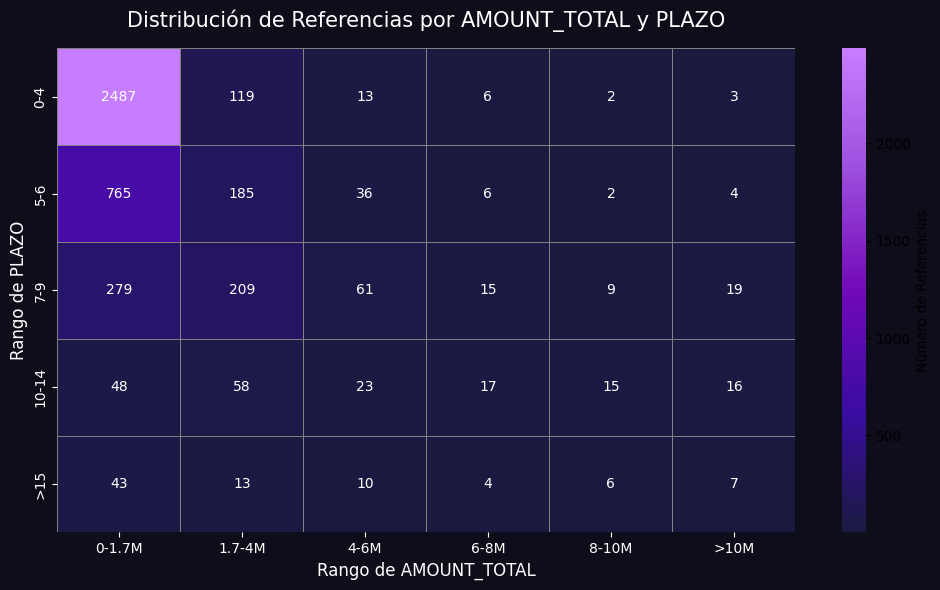

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# --- 1. Definir los rangos para AMOUNT_TOTAL ---
bins_amount = [0, 1_700_000, 4_000_000, 6_000_000, 8_000_000, 10_000_000, float('inf')]
labels_amount = ['0-1.7M', '1.7-4M', '4-6M', '6-8M', '8-10M', '>10M']
df_final['Rango_AMOUNT'] = pd.cut(df_final['AMOUNT_TOTAL'], bins=bins_amount, labels=labels_amount, right=False)

# --- 2. Definir los rangos para PRI-ULT (PLAZO) ---
bins_plazo = [0, 4, 6, 9, 14, float('inf')]
labels_plazo = ['0-4', '5-6', '7-9', '10-14', '>15']
df_final['Rango_PLAZO'] = pd.cut(df_final['PRI-ULT'], bins=bins_plazo, labels=labels_plazo, right=False)

# --- 3. Crear la tabla de frecuencia (conteo de REFERENCIA) ---
tabla = df_final.groupby(['Rango_PLAZO', 'Rango_AMOUNT'])['REFERENCIA'].count().unstack(fill_value=0)

# --- 4. Crear paleta de colores personalizada ---
colores_personalizados = LinearSegmentedColormap.from_list(
    "azul_morado_oscuro",
    ["#1a1a40", "#3a0ca3", "#7209b7", "#9d4edd", "#c77dff"]
)

# --- 5. Graficar el heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla,
    annot=True,
    fmt='d',
    cmap=colores_personalizados,
    linewidths=0.4,
    linecolor='gray',
    cbar_kws={'label': 'Número de Referencias'}
)

plt.title('Distribución de Referencias por AMOUNT_TOTAL y PLAZO', fontsize=15, color='white', pad=15)
plt.xlabel('Rango de AMOUNT_TOTAL', fontsize=12, color='white')
plt.ylabel('Rango de PLAZO', fontsize=12, color='white')

# --- Fondo oscuro y estilo limpio ---
plt.gca().set_facecolor('#0e0e1a')
plt.gcf().patch.set_facecolor('#0e0e1a')
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()


In [181]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# =========================
# 1) Binning y limpieza
# =========================
df = df_final.copy()

# Rangos AMOUNT_TOTAL
bins_amount = [0, 1_700_000, 4_000_000, 6_000_000, 8_000_000, 10_000_000, np.inf]
labels_amount = ['0-1.7M', '1.7-4M', '4-6M', '6-8M', '8-10M', '>10M']
df['Rango_AMOUNT'] = pd.cut(df['AMOUNT_TOTAL'], bins=bins_amount, labels=labels_amount, right=False, include_lowest=True)

# Rangos PLAZO (PRI-ULT)
bins_plazo = [0, 4, 6, 9, 14, np.inf]
labels_plazo = ['0-4', '5-6', '7-9', '10-14', '>15']
df['Rango_PLAZO'] = pd.cut(df['PRI-ULT'], bins=bins_plazo, labels=labels_plazo, right=False, include_lowest=True)

# Cohortes a 3 grupos
def map_cohorte(x):
    if x in ['Siempre Al día', 'Recuperado']:
        return 'Al día'
    if str(x).upper() == 'INCOBRABLE':
        return 'Incobrable'
    if x == 'Mora vigente':
        return 'Mora vigente'
    return 'Otros'

df['Cohorte3'] = df['COHORTE_FINAL'].apply(map_cohorte)
df = df[df['Cohorte3'].isin(['Al día', 'Incobrable', 'Mora vigente'])].copy()

# Ordenar ejes
df['Rango_AMOUNT'] = df['Rango_AMOUNT'].cat.reorder_categories(labels_amount, ordered=True)
df['Rango_PLAZO']  = df['Rango_PLAZO'].cat.reorder_categories(labels_plazo, ordered=True)

# =========================
# 2) Tabla de proporciones
# =========================
g = df.groupby(['Rango_PLAZO', 'Rango_AMOUNT', 'Cohorte3'])['REFERENCIA'].nunique()
tabla = g.unstack('Cohorte3', fill_value=0)
totales = tabla.sum(axis=1).replace(0, np.nan)
prop = tabla.div(totales, axis=0)

# =========================
# 3) Matrices por cohorte
# =========================
y_labels = labels_plazo
x_labels = labels_amount

def to_matrix(df_prop, cohorte):
    m = []
    for y in y_labels:
        fila = []
        for x in x_labels:
            val = df_prop.loc[(y, x)][cohorte] if (y, x) in df_prop.index else np.nan
            fila.append(val)
        m.append(fila)
    return np.array(m, dtype=float)

Z_al_dia = to_matrix(prop, 'Al día')
Z_incobrable = to_matrix(prop, 'Incobrable')
Z_mora_vigente = to_matrix(prop, 'Mora vigente')

# =========================
# 4) Datos de texto y hover
# =========================
def percent_text(Z):
    return np.where(np.isnan(Z), "", (np.round(Z*100, 1)).astype(str) + "%")

text_al_dia = percent_text(Z_al_dia)
text_incobrable = percent_text(Z_incobrable)
text_mora_vigente = percent_text(Z_mora_vigente)

customdata = np.stack((Z_al_dia, Z_incobrable, Z_mora_vigente), axis=-1)

# =========================
# 5) Definir figura (sin mostrar)
# =========================
colorscale = [
    [0.0,  "#edf2fb"],  # blanco-azulado muy claro
    [0.25, "#b8c0ff"],
    [0.5, "#7b2cbf"],
    [0.75, "#5a189a"],
    [1.0, "#240046"]
]

fig = go.Figure()

# --- Trazas ---
for Z, text, name, vis in zip(
    [Z_al_dia, Z_incobrable, Z_mora_vigente],
    [text_al_dia, text_incobrable, text_mora_vigente],
    ['Al día', 'Incobrable', 'Mora vigente'],
    [True, False, False]
):
    fig.add_trace(
        go.Heatmap(
            z=Z,
            x=x_labels,
            y=y_labels,
            colorscale=colorscale,
            zmin=0, zmax=1,
            text=text,
            texttemplate="%{text}",
            textfont=dict(color="black"),
            customdata=customdata,
            hovertemplate=(
                "<b>PLAZO</b>: %{y}<br>"
                "<b>AMOUNT</b>: %{x}<br><br>"
                "Al día: %{customdata[0]:.1%}<br>"
                "Incobrable: %{customdata[1]:.1%}<br>"
                "Mora vigente: %{customdata[2]:.1%}<extra></extra>"
            ),
            visible=vis
        )
    )

# --- Dropdown y layout blanco ---
fig.update_layout(
    title=dict(
        text="Proporción por Cohorte en cada celda (AMOUNT × PLAZO)",
        x=0.5, xanchor="center", font=dict(color="black", size=18)
    ),
    xaxis=dict(title="Rango de AMOUNT_TOTAL", tickfont=dict(color="black"), titlefont=dict(color="black")),
    yaxis=dict(title="Rango de PLAZO (PRI-ULT)", tickfont=dict(color="black"), titlefont=dict(color="black")),
    paper_bgcolor="white",
    plot_bgcolor="white",
    updatemenus=[
        dict(
            type="dropdown",
            x=1.02, y=1.0,
            xanchor="left",
            buttons=[
                dict(label="Al día", method="update", args=[{"visible": [True, False, False]}]),
                dict(label="Incobrable", method="update", args=[{"visible": [False, True, False]}]),
                dict(label="Mora vigente", method="update", args=[{"visible": [False, False, True]}]),
            ],
            bgcolor="#eae6ff",
            bordercolor="#5a189a"
        )
    ],
    margin=dict(l=70, r=120, t=80, b=60),
)

/tmp/ipython-input-421454819.py:40: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [182]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================
# 1) Preparación de datos
# =========================
dfw = df_final.copy()

# Ratio seguro en [0,1]
dfw['Ratio_PP'] = (dfw['PP_Comision'] / dfw['AMOUNT_TOTAL']).replace([np.inf, -np.inf], np.nan).clip(0, 1)

# Rangos del ratio
ratio_bins  = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
ratio_lbls  = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
dfw['Rango_Ratio_PP'] = pd.cut(dfw['Ratio_PP'], bins=ratio_bins, labels=ratio_lbls, include_lowest=True)

# Rangos de plazos PRI-ULT
plazo_lbls = ['0–4', '5–6', '7–9', '10–14', '15+']
if np.issubdtype(dfw['PRI-ULT'].dtype, np.number):
    plazo_bins = [-np.inf, 4, 6, 9, 14, np.inf]
    dfw['Plazo_Bin'] = pd.cut(dfw['PRI-ULT'], bins=plazo_bins, labels=plazo_lbls, include_lowest=True, ordered=True)
else:
    dfw['Plazo_Bin'] = pd.Categorical(dfw['PRI-ULT'], categories=plazo_lbls, ordered=True)

# Conteos por (Cohorte, Plazo, Rango)
counts = (
    dfw.groupby(['COHORTE_FINAL', 'Plazo_Bin', 'Rango_Ratio_PP'], observed=True)
       .size().reset_index(name='count')
)

# Completar combinaciones faltantes con 0
cohortes = counts['COHORTE_FINAL'].dropna().unique().tolist()
full = (
    pd.MultiIndex.from_product([cohortes, plazo_lbls, ratio_lbls],
                               names=['COHORTE_FINAL','Plazo_Bin','Rango_Ratio_PP'])
      .to_frame(index=False)
      .merge(counts, how='left', on=['COHORTE_FINAL','Plazo_Bin','Rango_Ratio_PP'])
      .fillna({'count':0})
)

# ===== Clave: % del total de cada cohorte (todas las celdas suman 100% por cohorte) =====
tot_coh = full.groupby('COHORTE_FINAL')['count'].transform('sum')
full['pct_coh'] = np.where(tot_coh>0, full['count'] / tot_coh, 0.0)

# =========================
# 2) Subplots (un heatmap por cohorte)
# =========================
n = len(cohortes)
fig = make_subplots(
    rows=1, cols=n,
    subplot_titles=[str(c) for c in cohortes],
    horizontal_spacing=0.04
)

# Escala invertida (alto % = más oscuro)
colorscale = [
    [0.00, "#b39ddb"],  # claro (bajo %)
    [0.25, "#8c76b0"],
    [0.50, "#5c4b8a"],
    [0.75, "#2a3174"],
    [1.00, "#0b1e3a"]   # muy oscuro (alto %)
]

for i, coh in enumerate(cohortes, start=1):
    sub = full[full['COHORTE_FINAL'] == coh]

    # Matriz de % del total de la cohorte
    mat_val = (
        sub.pivot(index='Plazo_Bin', columns='Rango_Ratio_PP', values='pct_coh')
           .reindex(index=plazo_lbls, columns=ratio_lbls)
           .fillna(0)
    )

    # Texto en porcentaje
    text = (mat_val * 100).round(1).astype(str) + '%'

    # zmax per-cohorte para mantener escala 0-valor_máximo_de_esa_cohorte
    zmax_coh = float(mat_val.values.max()) if np.isfinite(mat_val.values.max()) else 1.0
    if zmax_coh == 0:
        zmax_coh = 1.0  # evita división por cero en escala plana

    fig.add_trace(
        go.Heatmap(
            z=mat_val.values,
            x=mat_val.columns.astype(str),
            y=mat_val.index.astype(str),
            colorscale=colorscale,
            zmin=0, zmax=zmax_coh,          # normalizado a la cohorte
            colorbar=dict(title='% del total<br>de la cohorte', tickformat='.0%'),
            showscale=(i==n),
            xgap=1, ygap=1,
            text=text.values,
            texttemplate="%{text}",
            textfont=dict(color='white', size=11),
            hovertemplate=(
                f"Cohorte: {coh}<br>"
                "Plazo: %{y}<br>"
                "Rango: %{x}<br>"
                "Porcentaje (del total cohorte): %{z:.1%}<extra></extra>"
            )
        ),
        row=1, col=i
    )

# Layout
fig.update_layout(
    title="Distribución de PP_Comision / AMOUNT_TOTAL por Cohorte y Plazo<br><sup>Color/Texto = % del total de la cohorte (todas las celdas suman 100%)</sup>",
    title_x=0.5,
    template='plotly_white',
    margin=dict(l=40, r=20, t=90, b=40)
)

for i in range(1, n+1):
    fig.update_xaxes(title_text="Rango del ratio", row=1, col=i)
fig.update_yaxes(title_text="Plazo (PRI-ULT)", row=1, col=1)

fig.show()

In [183]:
dfw

,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO,Monto,PP_Comision,Rango_AMOUNT,Rango_PLAZO,Ratio_PP,Rango_Ratio_PP,Plazo_Bin
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,6.897798e+05,3.448899e+05,1.168067e+06,689780.0,689780.0,588235.0,0-1.7M,0-4,0.852787,80-100%,0–4
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,4.778597e+05,1.592866e+05,4.957983e+05,477860.0,477860.0,579404.0,0-1.7M,0-4,1.000000,80-100%,0–4
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,1.647020e+06,8.235101e+05,9.183193e+06,624732.0,624732.0,505042.0,0-1.7M,5-6,0.306640,20-40%,5–6
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,9.799874e+05,1.633312e+06,1.167227e+06,979988.0,979988.0,181668.0,0-1.7M,7-9,0.185378,0-20%,5–6
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3.096815e+05,1.548408e+05,2.903824e+05,976050.0,309682.0,99597.0,0-1.7M,0-4,0.321611,20-40%,0–4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,9734026,2025-01-28,Cerrado,False,Siempre Al día,1,1,1,0,2.342403e+05,2.342403e+05,1.825210e+06,234240.0,234240.0,234240.0,0-1.7M,0-4,0.999999,80-100%,0–4
4476,98501254,2024-10-16,Cerrado,True,Recuperado,1,2,2,0.2626919868,3.418597e+05,3.418597e+05,2.821849e+06,341860.0,341860.0,341860.0,0-1.7M,0-4,1.000000,80-100%,0–4
4477,98702966,2024-09-30,Al día,True,Recuperado,5,3,6,0.8976457693,1.979920e+06,3.959840e+05,5.121008e+06,1979921.0,1979921.0,198319.0,1.7-4M,7-9,0.100165,0-20%,5–6
4478,98702966,2025-01-30,Mora 60,True,Mora vigente,16,3,17,1.144751985,1.533134e+07,9.582088e+06,7.524370e+06,6078401.0,6078401.0,1347899.0,>10M,>15,0.087918,0-20%,15+


In [184]:
# Crear un nuevo DataFrame con las columnas seleccionadas
df_seleccion = dfw[["REFERENCIA", "COHORTE_FINAL", "AMOUNT_TOTAL", "PAGO", "PRI-ULT", "Plazo_Bin", "Rango_AMOUNT", "Rango_Ratio_PP", "Ratio_PP"]].copy()
df_seleccion

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Plazo_Bin,Rango_AMOUNT,Rango_Ratio_PP,Ratio_PP
0,1001082965,Recuperado,6.897798e+05,689780.0,2,0–4,0-1.7M,80-100%,0.852787
1,1001082965,Recuperado,4.778597e+05,477860.0,1,0–4,0-1.7M,80-100%,1.000000
2,1001082965,INCOBRABLE,1.647020e+06,624732.0,5,5–6,0-1.7M,20-40%,0.306640
3,1001244516,Siempre Al día,9.799874e+05,979988.0,6,5–6,0-1.7M,0-20%,0.185378
4,1001833139,Siempre Al día,3.096815e+05,976050.0,2,0–4,0-1.7M,20-40%,0.321611
...,...,...,...,...,...,...,...,...,...
4475,9734026,Siempre Al día,2.342403e+05,234240.0,1,0–4,0-1.7M,80-100%,0.999999
4476,98501254,Recuperado,3.418597e+05,341860.0,2,0–4,0-1.7M,80-100%,1.000000
4477,98702966,Recuperado,1.979920e+06,1979921.0,6,5–6,1.7-4M,0-20%,0.100165
4478,98702966,Mora vigente,1.533134e+07,6078401.0,17,15+,>10M,0-20%,0.087918


In [185]:
#df_seleccion.to_excel("df_selec.xlsx", index=False)

In [186]:
import numpy as np

df_seleccion["PAGO"] = np.where(
    df_seleccion["PAGO"] > df_seleccion["AMOUNT_TOTAL"],
    df_seleccion["AMOUNT_TOTAL"],
    df_seleccion["PAGO"]
)

In [187]:
df_seleccion['Plazo_Bin'].unique()

['0–4', '5–6', '7–9', '10–14', '15+']
Categories (5, object): ['0–4' < '5–6' < '7–9' < '10–14' < '15+']

In [188]:
df_seleccion['Rango_Ratio_PP'].unique()

['80-100%', '20-40%', '0-20%', '40-60%', '60-80%', NaN]
Categories (5, object): ['0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

In [189]:
df_seleccion['Rango_AMOUNT'].unique()

['0-1.7M', '1.7-4M', '4-6M', '8-10M', '6-8M', '>10M']
Categories (6, object): ['0-1.7M' < '1.7-4M' < '4-6M' < '6-8M' < '8-10M' < '>10M']

In [190]:
pip install Dash

In [191]:
# app_heatmap.py
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, State
import socket

# ========= CARGA DE DATOS =========
# Usa df_seleccion si ya existe; si no, intenta leer df_seleccion.xlsx
try:
    df = df_seleccion.copy()
except NameError:
    df = pd.read_excel("df_seleccion.xlsx")

df.columns = [str(c).strip() for c in df.columns]
df["PAGO"] = pd.to_numeric(df["PAGO"], errors="coerce")

# Columnas base (las 3 dimensiones)
COLS = ["Plazo_Bin", "Rango_AMOUNT", "Rango_Ratio_PP"]

# Etiquetas amigables ↔ columnas reales
LABEL_BY_COL = {
    "Plazo_Bin": "Plazo",
    "Rango_AMOUNT": "Monto Originación",
    "Rango_Ratio_PP": "%Primer pago",
}
COL_BY_LABEL = {v: k for k, v in LABEL_BY_COL.items()}

# Opciones X/Y con etiquetas amigables
XY_OPTIONS = [{"label": LABEL_BY_COL[c], "value": c} for c in COLS]

# ORDEN FIJO de cada dimensión
ORDER = {
    "Plazo_Bin":       ['0–4', '5–6', '7–9', '10–14', '15+'],
    "Rango_Ratio_PP":  ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
    "Rango_AMOUNT":    ['0-1.7M', '1.7-4M', '4-6M', '6-8M', '8-10M', '>10M'],
}

# ========= UTILIDADES =========
def human_money(v: float) -> str:
    n = float(v)
    sign = "-" if n < 0 else ""
    n = abs(n)
    if n >= 1e9:  s = f"{n/1e9:.2f}B"
    elif n >= 1e6: s = f"{n/1e6:.2f}M"
    elif n >= 1e3: s = f"{n/1e3:.2f}K"
    else:         s = f"{n:.0f}"
    return f"{sign}${s}"

def build_matrices(df_in, x, y):
    sub = df_in[[x, y, "PAGO"]].dropna()
    if sub.empty:
        return np.zeros((1,1)), ["(sin datos)"], ["(sin datos)"]
    g = sub.groupby([y, x], dropna=False)["PAGO"].sum().reset_index()
    piv = g.pivot(index=y, columns=x, values="PAGO").fillna(0.0)

    # Reordenar columnas (X) y filas (Y) siguiendo ORDER; mantener sólo las presentes
    if x in ORDER:
        ordered_cols = [c for c in ORDER[x] if c in piv.columns] + [c for c in piv.columns if c not in ORDER[x]]
        piv = piv.reindex(columns=ordered_cols)
    else:
        piv = piv.reindex(sorted(piv.columns, key=str), axis=1)

    if y in ORDER:
        ordered_idx = [r for r in ORDER[y] if r in piv.index] + [r for r in piv.index if r not in ORDER[y]]
        piv = piv.reindex(index=ordered_idx)
    else:
        piv = piv.reindex(sorted(piv.index, key=str))

    return piv.values, list(map(str, piv.columns)), list(map(str, piv.index))

# Paleta morado→azul (claro→oscuro; oscuro = mayor)
COLOR_SCALE = [
    [0.00, "#f3e8ff"], [0.10, "#e0e7ff"], [0.25, "#c7d2fe"],
    [0.40, "#a5b4fc"], [0.55, "#a78bfa"], [0.70, "#7c3aed"],
    [0.85, "#4338ca"], [1.00, "#1e1b4b"]
]

def make_fig(Z_amt, xlab, ylab, xcol, ycol, metric, show_text, subtitle=""):
    # Altura dinámica para que se vea completo en Colab (≈ 44 px por fila + márgenes)
    height = max(460, 44 * max(1, len(ylab)) + 240)

    total = Z_amt.sum() if Z_amt.sum() != 0 else 1.0
    pct_text   = np.vectorize(lambda v: f"{v/total*100:.1f}%")(Z_amt)
    money_text = np.vectorize(human_money)(Z_amt)

    if show_text == "%":
        text, texttemplate = pct_text, "%{text}"
    elif show_text == "$":
        text, texttemplate = money_text, "%{text}"
    elif show_text == "ambas":
        text = np.char.add(np.char.add(money_text, "<br>"), pct_text)
        texttemplate = "%{text}"
    else:
        text, texttemplate = None, None

    # Hover: siempre % y $
    customdata = np.dstack([(Z_amt/total), Z_amt]).reshape(Z_amt.shape[0], Z_amt.shape[1], 2)
    hovertemplate = (
        "<b>%{yaxis.title.text}</b>: %{y}<br>"
        "<b>%{xaxis.title.text}</b>: %{x}<br>"
        "Proporción del total: %{customdata[0]:.3f}<br>"
        "Suma PAGO: %{customdata[1]:,}<extra></extra>"
    )

    if metric == "prop":
        Z_plot = (Z_amt/total)
        colorbar_title = "Proporción del total de PAGO"
    else:
        Z_plot = Z_amt
        colorbar_title = "Suma de PAGO"

    fig = go.Figure(go.Heatmap(
        z=Z_plot, x=xlab, y=ylab,
        colorscale=COLOR_SCALE,
        zmin=0, zmax=float(Z_plot.max()) if Z_plot.size else 1.0,
        text=text, texttemplate=texttemplate,
        customdata=customdata, hovertemplate=hovertemplate,
        showscale=True, colorbar=dict(title=colorbar_title)
    ))

    title = f"{'Proporción del total de PAGO' if metric=='prop' else 'Suma de PAGO'} — {LABEL_BY_COL[ycol]} vs {LABEL_BY_COL[xcol]}"
    if subtitle:
        title += f" — {subtitle}"

    fig.update_layout(
        title=title,
        xaxis_title=LABEL_BY_COL[xcol],
        yaxis_title=LABEL_BY_COL[ycol],
        # Mantener el orden específico y primer elemento ABAJO (autorange='reversed')
        xaxis=dict(categoryorder="array", categoryarray=xlab),
        yaxis=dict(categoryorder="array", categoryarray=ylab, autorange="reversed"),
        template="plotly_white",
        margin=dict(l=80, r=20, t=90, b=80),
        height=height
    )
    return fig

def find_free_port(start=8060, max_tries=50):
    port = start
    for _ in range(max_tries):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("", port))
                return port
            except OSError:
                port += 1
    raise OSError("No se encontró puerto libre.")

# ========= DASH APP =========
app = Dash(__name__)

app.layout = html.Div(
    style={"maxWidth": "1200px", "margin": "20px auto"},
    children=[
        html.H3("Heatmap interactivo — PAGO (morado/azul: oscuro = mayor)"),
        html.Div(style={"display": "flex", "gap": "12px", "flexWrap": "wrap"}, children=[
            html.Div([html.Label("Eje X"),
                      dcc.Dropdown(XY_OPTIONS, COLS[0], id="x-axis", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Eje Y"),
                      dcc.Dropdown(XY_OPTIONS, COLS[1], id="y-axis", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Métrica"),
                      dcc.RadioItems(
                          options=[{"label": " Proporción", "value": "prop"},
                                   {"label": " Monto ($)", "value": "amt"}],
                          value="prop", id="metric", inline=True)],),
            html.Div([html.Label("Etiquetas en celda"),
                      dcc.RadioItems(
                          options=[{"label": " %", "value": "%"},
                                   {"label": " $", "value": "$"},
                                   {"label": " Ambas", "value": "ambas"},
                                   {"label": " Ninguna", "value": "none"}],
                          value="%", id="cell-text", inline=True)],),
            # Facet dinámico: sólo “Ninguno” o “la que falta (automática)”
            html.Div([html.Label("Facet (filtrar por)"),
                      dcc.Dropdown([], "Ninguno", id="facet", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Valor del facet"),
                      dcc.Dropdown([], None, id="facet-value", clearable=False,
                                   placeholder="Selecciona un valor")],
                     style={"minWidth": "260px", "display": "none"}, id="facet-value-wrapper"),
        ]),
        dcc.Graph(id="heatmap", style={"height": "720px"})
    ]
)

# 1) Actualiza opciones del Facet según X/Y (elige la variable que falta)
@app.callback(
    Output("facet", "options"),
    Output("facet", "value"),
    Input("x-axis", "value"),
    Input("y-axis", "value"),
    prevent_initial_call=False
)
def sync_facet_options(xcol, ycol):
    remaining = [c for c in COLS if c not in [xcol, ycol]]
    if remaining:
        missing = remaining[0]
        options = [{"label": "Ninguno", "value": "Ninguno"},
                   {"label": LABEL_BY_COL[missing], "value": missing}]
        return options, "Ninguno"
    return [{"label": "Ninguno", "value": "Ninguno"}], "Ninguno"

# 2) Poblamos/mostramos el selector de valor del Facet
@app.callback(
    Output("facet-value-wrapper", "style"),
    Output("facet-value", "options"),
    Output("facet-value", "value"),
    Input("facet", "value"),
    State("facet-value", "value"),
)
def update_facet_values(facet, current_value):
    if facet is None or facet == "Ninguno" or facet not in df.columns:
        return {"minWidth": "260px", "display": "none"}, [], None
    vals = [v for v in ORDER.get(facet, []) if v in set(df[facet].dropna().astype(str))]
    if not vals:
        vals = sorted(df[facet].dropna().astype(str).unique(), key=str)
    options = [{"label": str(v), "value": v} for v in vals]
    value = current_value if current_value in vals else (vals[0] if vals else None)
    return {"minWidth": "260px", "display": "block"}, options, value

# 3) Construye el heatmap (con filtro de facet si aplica)
@app.callback(
    Output("heatmap", "figure"),
    Input("x-axis", "value"),
    Input("y-axis", "value"),
    Input("metric", "value"),
    Input("cell-text", "value"),
    Input("facet", "value"),
    Input("facet-value", "value"),
)
def update_fig(xcol, ycol, metric, show_text, facet, facet_value):
    # Evitar X==Y
    if xcol == ycol:
        ycol = [c for c in COLS if c != xcol][0]

    # Filtrado por facet (la variable restante) si corresponde
    df_use = df.copy()
    subtitle = ""
    if facet and facet != "Ninguno" and facet in df_use.columns and facet_value is not None:
        # asegurar string para comparar categorías con guiones/%
        df_use = df_use[df_use[facet].astype(str) == str(facet_value)]
        subtitle = f"{LABEL_BY_COL.get(facet, facet)} = {facet_value}"

    Z_amt, xlab, ylab = build_matrices(df_use, xcol, ycol)
    fig = make_fig(Z_amt, xlab, ylab, xcol, ycol, metric, show_text, subtitle=subtitle)
    return fig

# Lanzar en puerto libre (útil en Colab/Jupyter)
def find_free_port(start=8060, max_tries=50):
    port = start
    for _ in range(max_tries):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("", port))
                return port
            except OSError:
                port += 1
    raise OSError("No se encontró puerto libre.")

if __name__ == "__main__":
    free_port = find_free_port()
    print(f"Iniciando en http://localhost:{free_port}")
    app.run(debug=True, port=free_port)

Iniciando en http://localhost:8064


<IPython.core.display.Javascript object>

In [192]:
# app_heatmap.py
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, State
import socket

# ========= CARGA DE DATOS =========
# Usa df_seleccion si ya existe; si no, intenta leer df_seleccion.xlsx
try:
    df = df_seleccion.copy()
except NameError:
    df = pd.read_excel("df_seleccion.xlsx")

df.columns = [str(c).strip() for c in df.columns]
df["PAGO"] = pd.to_numeric(df["PAGO"], errors="coerce")

# Detectar la columna de monto total (AMOUNT_TOTAL)
_AMOUNT_ALIASES = {
    "amount_total",
    "amount",
    "total_amount",
    "monto_total",
    "amount_originacion",
    "monto_originacion",
    "monto_origen",
    "monto",
}
def find_amount_col(df_):
    # Busca por equivalencia case-insensitive
    lower_map = {c.lower(): c for c in df_.columns}
    for alias in _AMOUNT_ALIASES:
        if alias in lower_map:
            return lower_map[alias]
    # fallback: intenta algunas variantes con espacios/guiones
    for c in df_.columns:
        key = c.lower().replace(" ", "_").replace("-", "_")
        if key in _AMOUNT_ALIASES:
            return c
    raise KeyError(
        "No se encontró la columna de monto total. Agrega una columna como "
        "`AMOUNT_TOTAL`, `AMOUNT`, `MONTO_TOTAL`, etc."
    )

AMOUNT_COL = find_amount_col(df)
df[AMOUNT_COL] = pd.to_numeric(df[AMOUNT_COL], errors="coerce")

# Columnas base (las 3 dimensiones)
COLS = ["Plazo_Bin", "Rango_AMOUNT", "Rango_Ratio_PP"]

# Etiquetas amigables ↔ columnas reales
LABEL_BY_COL = {
    "Plazo_Bin": "Plazo",
    "Rango_AMOUNT": "Monto Originación",
    "Rango_Ratio_PP": "%Primer pago",
}
COL_BY_LABEL = {v: k for k, v in LABEL_BY_COL.items()}

# Opciones X/Y con etiquetas amigables
XY_OPTIONS = [{"label": LABEL_BY_COL[c], "value": c} for c in COLS]

# ORDEN FIJO de cada dimensión
ORDER = {
    "Plazo_Bin":       ['0–4', '5–6', '7–9', '10–14', '15+'],
    "Rango_Ratio_PP":  ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
    "Rango_AMOUNT":    ['0-1.7M', '1.7-4M', '4-6M', '6-8M', '8-10M', '>10M'],
}

# ========= UTILIDADES =========
def human_money(v: float) -> str:
    n = float(v)
    sign = "-" if n < 0 else ""
    n = abs(n)
    if n >= 1e9:  s = f"{n/1e9:.2f}B"
    elif n >= 1e6: s = f"{n/1e6:.2f}M"
    elif n >= 1e3: s = f"{n/1e3:.2f}K"
    else:         s = f"{n:.0f}"
    return f"{sign}${s}"

def _order_pivot(piv, x, y):
    # Reordenar columnas (X)
    if x in ORDER:
        ordered_cols = [c for c in ORDER[x] if c in piv.columns] + [c for c in piv.columns if c not in ORDER[x]]
        piv = piv.reindex(columns=ordered_cols)
    else:
        piv = piv.reindex(sorted(piv.columns, key=str), axis=1)
    # Reordenar filas (Y)
    if y in ORDER:
        ordered_idx = [r for r in ORDER[y] if r in piv.index] + [r for r in piv.index if r not in ORDER[y]]
        piv = piv.reindex(index=ordered_idx)
    else:
        piv = piv.reindex(sorted(piv.index, key=str))
    return piv

def build_matrices(df_in, x, y):
    """
    Construye matrices paralelas:
      - Z_pago:     Σ(PAGO) por celda
      - Z_amount:   Σ(AMOUNT_TOTAL) por celda
      - xlab, ylab: categorías ordenadas
    """
    sub = df_in[[x, y, "PAGO", AMOUNT_COL]].dropna(subset=[x, y])
    if sub.empty:
        Z0 = np.zeros((1, 1))
        return Z0, Z0, ["(sin datos)"], ["(sin datos)"]

    g = sub.groupby([y, x], dropna=False).agg(
        PAGO=("PAGO", "sum"),
        AMT=(AMOUNT_COL, "sum")
    ).reset_index()

    piv_pago   = g.pivot(index=y, columns=x, values="PAGO").fillna(0.0)
    piv_amount = g.pivot(index=y, columns=x, values="AMT").fillna(0.0)

    # Alinear y ordenar exactamente igual
    piv_pago   = _order_pivot(piv_pago,   x, y)
    piv_amount = piv_amount.reindex(index=piv_pago.index, columns=piv_pago.columns).fillna(0.0)

    return piv_pago.values, piv_amount.values, list(map(str, piv_pago.columns)), list(map(str, piv_pago.index))

# Paleta morado→azul (claro→oscuro; oscuro = mayor)
COLOR_SCALE = [
    [0.00, "#f3e8ff"], [0.10, "#e0e7ff"], [0.25, "#c7d2fe"],
    [0.40, "#a5b4fc"], [0.55, "#a78bfa"], [0.70, "#7c3aed"],
    [0.85, "#4338ca"], [1.00, "#1e1b4b"]
]

def make_fig(Z_ratio, Z_pago, Z_amount, xlab, ylab, xcol, ycol, metric, show_text, subtitle=""):
    """
    metric:
      - "prop": colorea por % pagado (PAGO/AMOUNT_TOTAL)
      - "amt":  colorea por Σ(PAGO) (útil para comparar pesos), pero el texto sigue siendo % pagado
    """
    # Altura dinámica
    height = max(460, 44 * max(1, len(ylab)) + 240)

    # Textos
    pct_text = np.vectorize(lambda v: f"{(v*100):.1f}%")(Z_ratio)
    pago_text = np.vectorize(human_money)(Z_pago)
    amt_text  = np.vectorize(human_money)(Z_amount)

    if show_text == "%":
        text, texttemplate = pct_text, "%{text}"
    elif show_text == "$":
        # Muestra "pagado / total" en pesos
        text = np.char.add(np.char.add(pago_text, " / "), amt_text)
        texttemplate = "%{text}"
    elif show_text == "ambas":
        # % en primera línea y debajo "pagado / total"
        text = np.char.add(np.char.add(pct_text, "<br>"), np.char.add(pago_text, np.char.add(" / ", amt_text)))
        texttemplate = "%{text}"
    else:
        text, texttemplate = None, None

    # Hover siempre: % pagado, ΣPAGO y ΣAMOUNT
    customdata = np.dstack([Z_ratio, Z_pago, Z_amount]).reshape(Z_ratio.shape[0], Z_ratio.shape[1], 3)
    hovertemplate = (
        "<b>%{yaxis.title.text}</b>: %{y}<br>"
        "<b>%{xaxis.title.text}</b>: %{x}<br>"
        "% pagado: %{customdata[0]:.2%}<br>"
        "Σ PAGO: %{customdata[1]:,}<br>"
        "Σ MONTO (total): %{customdata[2]:,}<extra></extra>"
    )

    if metric == "prop":
        Z_plot = Z_ratio
        zmax   = 1.0
        colorbar_title = "% pagado"
    else:
        Z_plot = Z_pago
        zmax   = float(Z_plot.max()) if Z_plot.size else 1.0
        colorbar_title = "Σ PAGO"

    fig = go.Figure(go.Heatmap(
        z=Z_plot, x=xlab, y=ylab,
        colorscale=COLOR_SCALE,
        zmin=0, zmax=zmax,
        text=text, texttemplate=texttemplate,
        customdata=customdata, hovertemplate=hovertemplate,
        showscale=True, colorbar=dict(title=colorbar_title)
    ))

    title_core = "% pagado (PAGO/AMOUNT_TOTAL)" if metric == "prop" else "Suma de PAGO (color) + % pagado en hover"
    title = f"{title_core} — {LABEL_BY_COL[ycol]} vs {LABEL_BY_COL[xcol]}"
    if subtitle:
        title += f" — {subtitle}"

    fig.update_layout(
        title=title,
        xaxis_title=LABEL_BY_COL[xcol],
        yaxis_title=LABEL_BY_COL[ycol],
        xaxis=dict(categoryorder="array", categoryarray=xlab),
        yaxis=dict(categoryorder="array", categoryarray=ylab, autorange="reversed"),
        template="plotly_white",
        margin=dict(l=80, r=20, t=90, b=80),
        height=height
    )
    return fig

def find_free_port(start=8060, max_tries=50):
    port = start
    for _ in range(max_tries):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("", port))
                return port
            except OSError:
                port += 1
    raise OSError("No se encontró puerto libre.")

# ========= DASH APP =========
app = Dash(__name__)

app.layout = html.Div(
    style={"maxWidth": "1200px", "margin": "20px auto"},
    children=[
        html.H3("Heatmap interactivo — % pagado (ΣPAGO / ΣAMOUNT_TOTAL)"),
        html.Div(style={"display": "flex", "gap": "12px", "flexWrap": "wrap"}, children=[
            html.Div([html.Label("Eje X"),
                      dcc.Dropdown(XY_OPTIONS, COLS[0], id="x-axis", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Eje Y"),
                      dcc.Dropdown(XY_OPTIONS, COLS[1], id="y-axis", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Métrica"),
                      dcc.RadioItems(
                          options=[{"label": " Proporción (% pagado)", "value": "prop"},
                                   {"label": " Monto ($) — usa ΣPAGO", "value": "amt"}],
                          value="prop", id="metric", inline=True)],),
            html.Div([html.Label("Etiquetas en celda"),
                      dcc.RadioItems(
                          options=[{"label": " %", "value": "%"},
                                   {"label": " $ (pagado/total)", "value": "$"},
                                   {"label": " Ambas", "value": "ambas"},
                                   {"label": " Ninguna", "value": "none"}],
                          value="%", id="cell-text", inline=True)],),
            # Facet dinámico: sólo “Ninguno” o “la que falta (automática)”
            html.Div([html.Label("Facet (filtrar por)"),
                      dcc.Dropdown([], "Ninguno", id="facet", clearable=False)],
                     style={"minWidth": "240px"}),
            html.Div([html.Label("Valor del facet"),
                      dcc.Dropdown([], None, id="facet-value", clearable=False,
                                   placeholder="Selecciona un valor")],
                     style={"minWidth": "260px", "display": "none"}, id="facet-value-wrapper"),
        ]),
        dcc.Graph(id="heatmap", style={"height": "720px"})
    ]
)

# 1) Actualiza opciones del Facet según X/Y (elige la variable que falta)
@app.callback(
    Output("facet", "options"),
    Output("facet", "value"),
    Input("x-axis", "value"),
    Input("y-axis", "value"),
    prevent_initial_call=False
)
def sync_facet_options(xcol, ycol):
    remaining = [c for c in COLS if c not in [xcol, ycol]]
    if remaining:
        missing = remaining[0]
        options = [{"label": "Ninguno", "value": "Ninguno"},
                   {"label": LABEL_BY_COL[missing], "value": missing}]
        return options, "Ninguno"
    return [{"label": "Ninguno", "value": "Ninguno"}], "Ninguno"

# 2) Poblamos/mostramos el selector de valor del Facet
@app.callback(
    Output("facet-value-wrapper", "style"),
    Output("facet-value", "options"),
    Output("facet-value", "value"),
    Input("facet", "value"),
    State("facet-value", "value"),
)
def update_facet_values(facet, current_value):
    if facet is None or facet == "Ninguno" or facet not in df.columns:
        return {"minWidth": "260px", "display": "none"}, [], None
    vals = [v for v in ORDER.get(facet, []) if v in set(df[facet].dropna().astype(str))]
    if not vals:
        vals = sorted(df[facet].dropna().astype(str).unique(), key=str)
    options = [{"label": str(v), "value": v} for v in vals]
    value = current_value if current_value in vals else (vals[0] if vals else None)
    return {"minWidth": "260px", "display": "block"}, options, value

# 3) Construye el heatmap (con filtro de facet si aplica)
@app.callback(
    Output("heatmap", "figure"),
    Input("x-axis", "value"),
    Input("y-axis", "value"),
    Input("metric", "value"),
    Input("cell-text", "value"),
    Input("facet", "value"),
    Input("facet-value", "value"),
)
def update_fig(xcol, ycol, metric, show_text, facet, facet_value):
    # Evitar X==Y
    if xcol == ycol:
        ycol = [c for c in COLS if c != xcol][0]

    # Filtrado por facet (la variable restante) si corresponde
    df_use = df.copy()
    subtitle = ""
    if facet and facet != "Ninguno" and facet in df_use.columns and facet_value is not None:
        df_use = df_use[df_use[facet].astype(str) == str(facet_value)]
        subtitle = f"{LABEL_BY_COL.get(facet, facet)} = {facet_value}"

    Z_pago, Z_amount, xlab, ylab = build_matrices(df_use, xcol, ycol)
    # % pagado por celda: PAGO / AMOUNT_TOTAL (maneja divisiones por 0)
    Z_ratio = np.divide(Z_pago, Z_amount, out=np.zeros_like(Z_pago, dtype=float), where=(Z_amount != 0))

    fig = make_fig(Z_ratio, Z_pago, Z_amount, xlab, ylab, xcol, ycol, metric, show_text, subtitle=subtitle)
    return fig

# Lanzar en puerto libre (útil en Colab/Jupyter)
def find_free_port(start=8060, max_tries=50):
    port = start
    for _ in range(max_tries):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("", port))
                return port
            except OSError:
                port += 1
    raise OSError("No se encontró puerto libre.")

if __name__ == "__main__":
    free_port = find_free_port()
    print(f"Iniciando en http://localhost:{free_port}")
    app.run(debug=True, port=free_port)

Iniciando en http://localhost:8065


<IPython.core.display.Javascript object>

In [193]:
dfw

,REFERENCIA,FECHA_ORIGEN,MORA_STATUS_ULTIMO,ALGUNA_VEZ_MORA,COHORTE_FINAL,N_PAGOS,N_PAGOS_PAB,PRI-ULT,C/A,AMOUNT_TOTAL,AMOUNT_PROMEDIO,PAB_TOTAL,PAGO,Monto,PP_Comision,Rango_AMOUNT,Rango_PLAZO,Ratio_PP,Rango_Ratio_PP,Plazo_Bin
0,1001082965,2024-11-18,Al día,True,Recuperado,2,1,2,0.04922800754,6.897798e+05,3.448899e+05,1.168067e+06,689780.0,689780.0,588235.0,0-1.7M,0-4,0.852787,80-100%,0–4
1,1001082965,2024-12-23,Al día,True,Recuperado,3,3,1,0,4.778597e+05,1.592866e+05,4.957983e+05,477860.0,477860.0,579404.0,0-1.7M,0-4,1.000000,80-100%,0–4
2,1001082965,2025-01-31,Mora 120,True,INCOBRABLE,2,4,5,1.005446711,1.647020e+06,8.235101e+05,9.183193e+06,624732.0,624732.0,505042.0,0-1.7M,5-6,0.306640,20-40%,5–6
3,1001244516,2024-06-24,Cerrado,False,Siempre Al día,6,4,6,1.823532276,9.799874e+05,1.633312e+06,1.167227e+06,979988.0,979988.0,181668.0,0-1.7M,7-9,0.185378,0-20%,5–6
4,1001833139,2024-03-15,Cerrado,False,Siempre Al día,2,1,2,1.454545468,3.096815e+05,1.548408e+05,2.903824e+05,976050.0,309682.0,99597.0,0-1.7M,0-4,0.321611,20-40%,0–4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,9734026,2025-01-28,Cerrado,False,Siempre Al día,1,1,1,0,2.342403e+05,2.342403e+05,1.825210e+06,234240.0,234240.0,234240.0,0-1.7M,0-4,0.999999,80-100%,0–4
4476,98501254,2024-10-16,Cerrado,True,Recuperado,1,2,2,0.2626919868,3.418597e+05,3.418597e+05,2.821849e+06,341860.0,341860.0,341860.0,0-1.7M,0-4,1.000000,80-100%,0–4
4477,98702966,2024-09-30,Al día,True,Recuperado,5,3,6,0.8976457693,1.979920e+06,3.959840e+05,5.121008e+06,1979921.0,1979921.0,198319.0,1.7-4M,7-9,0.100165,0-20%,5–6
4478,98702966,2025-01-30,Mora 60,True,Mora vigente,16,3,17,1.144751985,1.533134e+07,9.582088e+06,7.524370e+06,6078401.0,6078401.0,1347899.0,>10M,>15,0.087918,0-20%,15+


In [194]:
#dfw.to_excel('dfw.xlsx', index=False)

#C/A

In [195]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

# --- Base ---
df = dfw.copy()

# --- Orden y colores de cohortes ---
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# --- Limpieza/normalización de C/A -> numérico ---
ca_num = (
    df['C/A']
      .astype(str)
      .str.replace(',', '.', regex=False)
      .str.replace(r'[^\d\.\-]+', '', regex=True)
)
df['C/A_NUM'] = pd.to_numeric(ca_num, errors='coerce')

# --- Filtrar: C/A_NUM >= 0.01, no NaN, cohorte válida ---
df = df[(df['C/A_NUM'].notna()) & (df['C/A_NUM'] >= 0.01) & (df['COHORTE_FINAL'].notna())].copy()

# --- Cohorte categórica ordenada ---
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=cohort_order, ordered=True)

# ===== 1) Rangos de C/A =====
bins   = [0.01, 0.5, 0.8, 1.0, 1.15, 1.5, np.inf]
labels = ['0.01-0.5', '0.5-0.8', '0.8-1', '1-1.15', '1.15-1.5', '>1.5']
df['RANGO_C/A'] = pd.cut(df['C/A_NUM'], bins=bins, labels=labels, right=False, ordered=True)

# ============================================================
# 1) GRÁFICA INTERACTIVA: % DE CASOS POR RANGO_C/A (X) Y COHORTE (APILADO)
# ============================================================
tabla = (
    df.groupby(["RANGO_C/A", "COHORTE_FINAL"], observed=True)
      .size().reset_index(name="Conteo")
)

# Asegurar todas las combinaciones rango×cohorte (evita huecos)
full_index = pd.MultiIndex.from_product([labels, cohort_order],
                                        names=["RANGO_C/A", "COHORTE_FINAL"])
tabla = (tabla.set_index(["RANGO_C/A", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# Porcentaje dentro de cada rango (suma 100% por barra)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("RANGO_C/A")["Conteo"].transform("sum") * 100
).fillna(0)

fig1 = px.bar(
    tabla,
    x="RANGO_C/A",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"RANGO_C/A": labels, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución por RANGO_C/A (en % de casos) y Cohorte",
    text="Porcentaje"
)
fig1.update_layout(
    barmode="stack",
    yaxis_title="Porcentaje de casos",
    xaxis_title="Rangos de C/A",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig1.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig1.show()

# ============================================================
# 2) GRÁFICA INTERACTIVA: CANTIDAD DE CASOS POR RANGO_C/A
# ============================================================
conteo_rango = (
    df.groupby("RANGO_C/A", observed=True)
      .size().reindex(labels, fill_value=0)
      .reset_index(name="Casos")
)

fig2 = px.bar(
    conteo_rango,
    x="RANGO_C/A",
    y="Casos",
    title="Cantidad de casos por RANGO_C/A",
    text="Casos",
    category_orders={"RANGO_C/A": labels}
)
fig2.update_layout(
    yaxis_title="Número de casos",
    xaxis_title="Rangos de C/A",
    template="plotly_white"
)
fig2.update_traces(textposition="outside")
fig2.show()

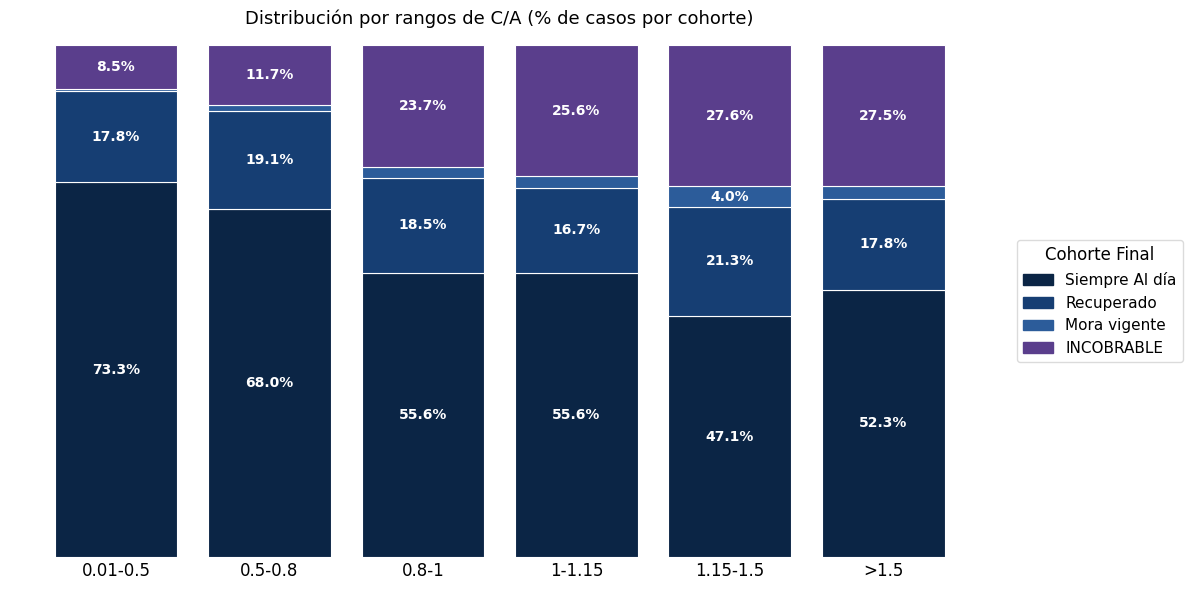

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# =====================
# 1) Cargar y limpiar datos
# =====================
df = dfw.copy()

# --- Limpieza de C/A a numérico ---
ca_num = (
    df['C/A']
      .astype(str)
      .str.replace(',', '.', regex=False)
      .str.replace(r'[^\d\.\-]+', '', regex=True)
)
df['C/A_NUM'] = pd.to_numeric(ca_num, errors='coerce')

# --- Filtro: C/A_NUM >= 0.01, no NaN, cohorte válida ---
df = df[(df['C/A_NUM'].notna()) & (df['C/A_NUM'] >= 0.01) & (df['COHORTE_FINAL'].notna())].copy()

# =====================
# 2) Definir rangos y cohortes
# =====================
bins = [0.01, 0.5, 0.8, 1.0, 1.15, 1.5, np.inf]
labels = ['0.01-0.5', '0.5-0.8', '0.8-1', '1-1.15', '1.15-1.5', '>1.5']
orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# Variable categórica ordenada de rangos
df["RANGO_C/A"] = pd.cut(
    df["C/A_NUM"], bins=bins, labels=labels,
    right=False, include_lowest=True, ordered=True
)

# Cohorte categórica ordenada
df["COHORTE_FINAL"] = pd.Categorical(
    df["COHORTE_FINAL"], categories=orden_cohortes, ordered=True
)

# =====================
# 3) Tabla de % por rango (X) y cohorte (apilado)
# =====================
tabla = (
    df.groupby(["RANGO_C/A", "COHORTE_FINAL"], observed=True)
      .size().reset_index(name="Conteo")
)

# Asegurar todas las combinaciones (rango x cohorte)
full_index = pd.MultiIndex.from_product([labels, orden_cohortes],
                                        names=["RANGO_C/A", "COHORTE_FINAL"])
tabla = (tabla.set_index(["RANGO_C/A", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# Porcentaje dentro de cada rango (suma 100% por barra)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("RANGO_C/A")["Conteo"].transform("sum") * 100
).fillna(0)

# Pivot: filas = rangos, columnas = cohortes
pct = (
    tabla.pivot(index="RANGO_C/A", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=labels, columns=orden_cohortes)
         .fillna(0)
)

# =====================
# 4) Gráfico minimalista Matplotlib
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh], edgecolor='white', linewidth=0.8)
    # Etiquetas dentro de la barra (solo si el segmento >= 3%)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# Estilo limpio
ax.set_xticks(x)
ax.set_xticklabels(pct.index, rotation=0, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top','right','left','bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Leyenda
handles = [
    mpatches.Patch(color=colores['Siempre Al día'], label='Siempre Al día'),
    mpatches.Patch(color=colores['Recuperado'],     label='Recuperado'),
    mpatches.Patch(color=colores['Mora vigente'],   label='Mora vigente'),
    mpatches.Patch(color=colores['INCOBRABLE'],     label='INCOBRABLE'),
]

plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

plt.title("Distribución por rangos de C/A (% de casos por cohorte)", fontsize=13, pad=15)
plt.tight_layout()
plt.show()

# (Opcional) Guardar imagen
# fig.savefig("distribucion_CA_por_rango_cohorte.png", dpi=150, bbox_inches="tight")

In [197]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Base ---
df = dfw.copy()

# --- Orden y colores de cohortes ---
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# --- C/A -> numérico (como indicas) ---
ca_num = (
    df['C/A']
      .astype(str)
      .str.replace(',', '.', regex=False)
      .str.replace(r'[^\d\.\-]+', '', regex=True)
)
df['C/A_NUM'] = pd.to_numeric(ca_num, errors='coerce')

# --- Filtrar: C/A_NUM >= 0.01, no NaN, cohorte válida ---
df = df[(df['C/A_NUM'].notna()) & (df['C/A_NUM'] >= 0.01) & (df['COHORTE_FINAL'].notna())].copy()

# --- Preparar columnas ---
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce").fillna(0.0)
df["PAGO"]         = pd.to_numeric(df["PAGO"], errors="coerce").fillna(0.0)
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=cohort_order, ordered=True)

# --- Rangos de C/A ---
bins   = [0.01, 0.5, 0.8, 1.0, 1.15, 1.5, np.inf]
labels = ['0.01-0.5', '0.5-0.8', '0.8-1', '1-1.15', '1.15-1.5', '>1.5']
df['RANGO_C/A'] = pd.cut(df['C/A_NUM'], bins=bins, labels=labels,
                         right=False, include_lowest=True, ordered=True)

# ============================================================
# AJUSTE DE MONTO:
#   - Si cohorte ∈ {INCOBRABLE, Mora vigente}: divide AMOUNT_TOTAL en:
#       a) PAGO_cap -> 'Recuperado'
#       b) AMOUNT_TOTAL - PAGO_cap -> cohorte original
#   - Else: todo AMOUNT_TOTAL a su cohorte original
# ============================================================
ajustados = []
for _, row in df.iterrows():
    coh = row["COHORTE_FINAL"]
    total = float(row["AMOUNT_TOTAL"])
    pago_cap = min(float(row["PAGO"]), total)

    if coh in ["INCOBRABLE", "Mora vigente"]:
        # Parte a Recuperado
        if pago_cap > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": "Recuperado",
                "MONTO_AJUSTADO": pago_cap
            })
        # Resto se queda en cohorte original
        restante = total - pago_cap
        if restante > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": restante
            })
    else:
        if total > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": total
            })

df_adj = pd.DataFrame(ajustados)
df_adj["COHORTE_FINAL"] = pd.Categorical(df_adj["COHORTE_FINAL"],
                                         categories=cohort_order, ordered=True)

# ============================================================
# 1) % DEL MONTO AJUSTADO POR RANGO_C/A Y COHORTE (100% apilado)
# ============================================================
tabla = (
    df_adj.groupby(["RANGO_C/A", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
          .sum().reset_index(name="Monto")
)

# Asegurar todas las combinaciones rango×cohorte
full_index = pd.MultiIndex.from_product([labels, cohort_order],
                                        names=["RANGO_C/A", "COHORTE_FINAL"])
tabla = (tabla.set_index(["RANGO_C/A", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0.0)
              .reset_index())

# % por rango (suma 100% por barra)
tot_rango = tabla.groupby("RANGO_C/A")["Monto"].transform("sum").replace(0, np.nan)
tabla["Porcentaje"] = ((tabla["Monto"] / tot_rango) * 100).fillna(0.0)

fig1 = px.bar(
    tabla,
    x="RANGO_C/A",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"RANGO_C/A": labels, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución por RANGO_C/A (% del monto ajustado por pagos)",
    text="Porcentaje"
)
fig1.update_layout(
    barmode="stack",
    yaxis_title="% del monto ajustado",
    xaxis_title="Rangos de C/A",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig1.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig1.show()

# ============================================================
# 2) MONTO AJUSTADO TOTAL POR RANGO_C/A
# ============================================================
monto_rango = (
    df_adj.groupby("RANGO_C/A", observed=True)["MONTO_AJUSTADO"]
          .sum().reindex(labels, fill_value=0.0)
          .reset_index(name="Monto_Ajustado_Total")
)

fig2 = px.bar(
    monto_rango,
    x="RANGO_C/A",
    y="Monto_Ajustado_Total",
    title="Monto ajustado total por RANGO_C/A (PAGO→Recuperado; resto→cohorte original)",
    text="Monto_Ajustado_Total",
    category_orders={"RANGO_C/A": labels}
)
fig2.update_layout(
    yaxis_title="Monto ajustado",
    xaxis_title="Rangos de C/A",
    template="plotly_white"
)
fig2.update_traces(textposition="outside", texttemplate="%{text:,.0f}")
fig2.show()

/tmp/ipython-input-1458501777.py:107: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/tmp/ipython-input-1542625663.py in update_fig(
    xcol='Plazo_Bin',
    ycol='Rango_AMOUNT',
    metric='prop',
    show_text='%',
    facet='Ninguno',
    facet_value=None
)
    245         subtitle = f"{LABEL_BY_COL.get(facet, facet)} = {facet_value}"
    246 
--> 247     Z_amt, xlab, ylab = build_matrices(df_use, xcol, ycol)
        Z_amt = undefined
        xlab = undefined
        ylab = undefined
        global build_matrices = <function build_matrices at 0x795dab7bbe20>
        df_use =       REFERENCIA FECHA_ORIGEN MORA_STATUS_ULTIMO  ALGUNA_VEZ_MORA  \
0     1001082965   2024-11-18             Al día             True   
2     1001082965   2025-01-31           Mora 120             True   
3     1001244516   2024-06-24            Cerrado            False   
4     1001833139   2024-03-15            Cerrado            False   
5 

/tmp/ipython-input-1458501777.py:107: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



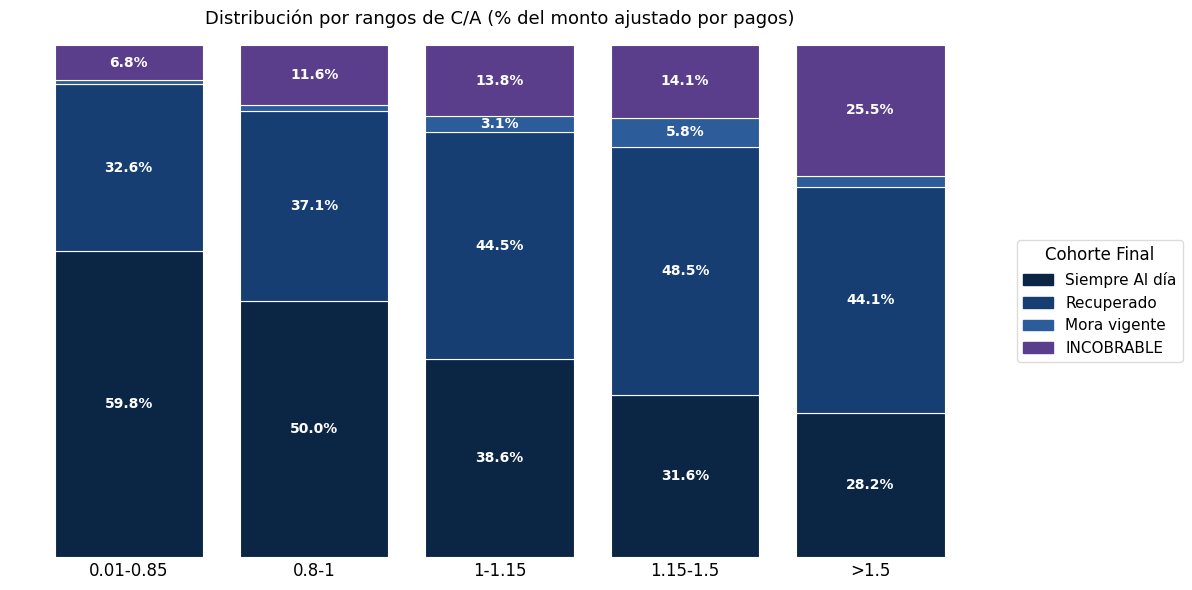

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# =====================
# 1) Cargar y limpiar datos
# =====================
df = dfw.copy()

# --- C/A a numérico (tal cual tu regla) ---
ca_num = (
    df['C/A']
      .astype(str)
      .str.replace(',', '.', regex=False)
      .str.replace(r'[^\d\.\-]+', '', regex=True)
)
df['C/A_NUM'] = pd.to_numeric(ca_num, errors='coerce')

# --- Filtro base sobre C/A ---
df = df[(df['C/A_NUM'].notna()) & (df['C/A_NUM'] >= 0.01) & (df['COHORTE_FINAL'].notna())].copy()

# Asegurar numéricos para monto/pago
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce").fillna(0.0)
df["PAGO"]         = pd.to_numeric(df["PAGO"], errors="coerce").fillna(0.0)

# =====================
# 2) Definir rangos y cohortes
# =====================
bins = [0.00001, 0.85, 1.0, 1.15, 1.5, np.inf]
labels = ['0.01-0.85', '0.8-1', '1-1.15', '1.15-1.5', '>1.5']
orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# Rango por C/A
df["RANGO_C/A"] = pd.cut(
    df["C/A_NUM"], bins=bins, labels=labels,
    right=False, include_lowest=True, ordered=True
)

# Cohorte categórica ordenada
df["COHORTE_FINAL"] = pd.Categorical(
    df["COHORTE_FINAL"], categories=orden_cohortes, ordered=True
)

# =====================
# 3) Construir MONTO_AJUSTADO según tu regla (PAGO -> Recuperado; resto -> cohorte original)
# =====================
ajustados = []
for _, row in df.iterrows():
    coh = row["COHORTE_FINAL"]
    total = float(row["AMOUNT_TOTAL"])
    pago_cap = min(float(row["PAGO"]), total)

    if coh in ["INCOBRABLE", "Mora vigente"]:
        # Parte hacia Recuperado
        if pago_cap > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": "Recuperado",
                "MONTO_AJUSTADO": pago_cap
            })
        # Resto queda en la cohorte original
        restante = total - pago_cap
        if restante > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": restante
            })
    else:
        if total > 0:
            ajustados.append({
                "RANGO_C/A": row["RANGO_C/A"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": total
            })

df_adj = pd.DataFrame(ajustados)
df_adj["COHORTE_FINAL"] = pd.Categorical(df_adj["COHORTE_FINAL"],
                                         categories=orden_cohortes, ordered=True)

# =====================
# 4) Tabla de % por rango (X) y cohorte (apilado) usando MONTO_AJUSTADO
# =====================
tabla = (
    df_adj.groupby(["RANGO_C/A", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
          .sum().reset_index(name="Monto")
)

# Asegurar todas las combinaciones (rango x cohorte)
full_index = pd.MultiIndex.from_product([labels, orden_cohortes],
                                        names=["RANGO_C/A", "COHORTE_FINAL"])
tabla = (tabla.set_index(["RANGO_C/A", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0.0)
              .reset_index())

# Porcentaje dentro de cada rango (suma 100% por barra)
tot_rango = tabla.groupby("RANGO_C/A")["Monto"].transform("sum").replace(0, np.nan)
tabla["Porcentaje"] = ((tabla["Monto"] / tot_rango) * 100).fillna(0.0)

# Pivot para graficar
pct = (
    tabla.pivot(index="RANGO_C/A", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=labels, columns=orden_cohortes)
         .fillna(0.0)
)

# =====================
# 5) Gráfico minimalista Matplotlib (100% apilado por % de monto)
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh], edgecolor='white', linewidth=0.8)
    # Etiquetas dentro de la barra (solo si el segmento >= 3%)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# Estilo limpio
ax.set_xticks(x)
ax.set_xticklabels(pct.index, rotation=0, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top','right','left','bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Leyenda
handles = [
    mpatches.Patch(color=colores['Siempre Al día'], label='Siempre Al día'),
    mpatches.Patch(color=colores['Recuperado'],     label='Recuperado'),
    mpatches.Patch(color=colores['Mora vigente'],   label='Mora vigente'),
    mpatches.Patch(color=colores['INCOBRABLE'],     label='INCOBRABLE'),
]

plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

plt.title("Distribución por rangos de C/A (% del monto ajustado por pagos)", fontsize=13, pad=15)
plt.tight_layout()
plt.show()

# (Opcional) Guardar imagen
# fig.savefig("distribucion_CA_por_rango_monto_ajustado.png", dpi=150, bbox_inches="tight")

#MONTO ORIGINACIÓN

In [199]:
import pandas as pd
import plotly.express as px
import itertools

# --- Cargar datos ---
df = dfw.copy()

# --- Definir rangos y cohortes (orden + colores) ---
bins = [0,  1_700_000, 4_000_000, 6_000_000, 8_000_000, float('inf')]
labels = [
    "0 a 1.700.000",
    "1.700.000 a 4.000.000",
    "4.000.000 a 6.000.000",
    "6.000.000 a 8.000.000",
    "Más de 8.000.000"
]
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# --- Variable de rangos categórica ordenada ---
df["Rango_Monto"] = pd.cut(
    df["AMOUNT_TOTAL"], bins=bins, labels=labels,
    right=False, include_lowest=True, ordered=True
)

# --- Cohorte categórica ordenada (por si faltan categorías en los datos) ---
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=cohort_order, ordered=True)

# ============================================================
# 1) GRÁFICA INTERACTIVA: % DE CASOS POR RANGO (X) Y COHORTE (APILADO)
# ============================================================

# Conteo por Rango y Cohorte (cada fila es un caso)
tabla = (
    df.groupby(["Rango_Monto", "COHORTE_FINAL"], observed=True)
      .size().reset_index(name="Conteo")
)

# Asegurar que existan todas las combinaciones (para que se vean todos los segmentos)
full_index = pd.MultiIndex.from_product([labels, cohort_order],
                                        names=["Rango_Monto", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Monto", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# Porcentaje dentro de cada Rango (suma 100% por barra)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("Rango_Monto")["Conteo"].transform("sum") * 100
).fillna(0)

fig1 = px.bar(
    tabla,
    x="Rango_Monto",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"Rango_Monto": labels, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución de AMOUNT_TOTAL por Rango y Cohorte (en % de casos)",
    text="Porcentaje"
)
fig1.update_layout(
    barmode="stack",
    yaxis_title="Porcentaje de casos",
    xaxis_title="Rangos de AMOUNT_TOTAL",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig1.update_traces(texttemplate="%{text:.1f}%", textposition="inside")

fig1.show()

# ============================================================
# 2) GRÁFICA INTERACTIVA: CANTIDAD DE CASOS POR RANGO (X)
#    (cada fila cuenta, no referencias únicas)
# ============================================================

conteo_rango = (
    df.groupby("Rango_Monto", observed=True)
      .size().reindex(labels, fill_value=0)
      .reset_index(name="Casos")
)

fig2 = px.bar(
    conteo_rango,
    x="Rango_Monto",
    y="Casos",
    title="Cantidad de casos por Rango de AMOUNT_TOTAL",
    text="Casos"
)
fig2.update_layout(
    yaxis_title="Número de casos",
    xaxis_title="Rangos de AMOUNT_TOTAL",
    template="plotly_white"
)
fig2.update_traces(textposition="outside")

fig2.show()

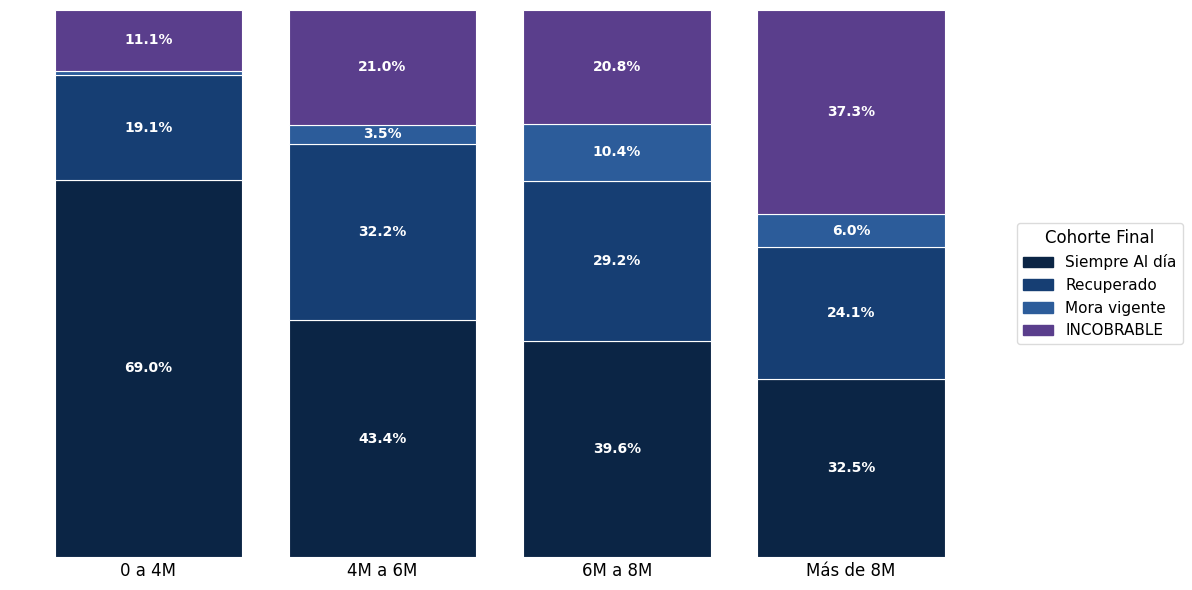

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# =====================
# 1) Cargar datos
# =====================
df = dfw.copy()

# =====================
# 2) Definir rangos y cohortes (mismo setup que el código anterior)
# =====================
bins = [0, 4_000_000, 6_000_000, 8_000_000, float('inf')]
labels = [
    "0 a 4M",
    "4M a 6M",
    "6M a 8M",
    "Más de 8M"
]
orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# Variable categórica ordenada de rangos
df["Rango_Monto"] = pd.cut(
    df["AMOUNT_TOTAL"], bins=bins, labels=labels,
    right=False, include_lowest=True, ordered=True
)

# Cohorte categórica ordenada
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=orden_cohortes, ordered=True)

# =====================
# 3) Tabla de % por Rango (X) y Cohorte (apilado)
# =====================
# Conteo por rango y cohorte (cada fila/caso cuenta)
tabla = (
    df.groupby(["Rango_Monto", "COHORTE_FINAL"], observed=True)
      .size().reset_index(name="Conteo")
)

# Asegurar todas las combinaciones para que no falte ningún segmento
full_index = pd.MultiIndex.from_product([labels, orden_cohortes],
                                        names=["Rango_Monto", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Monto", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# % dentro de cada rango (suma 100% por barra)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("Rango_Monto")["Conteo"].transform("sum") * 100
).fillna(0)

# Pivot a formato ancho: filas = rangos, columnas = cohortes, valores = %
pct = (
    tabla.pivot(index="Rango_Monto", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=labels, columns=orden_cohortes)
         .fillna(0)
)

# =====================
# 4) Gráfico minimalista estilo Matplotlib (como tu ejemplo)
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh], edgecolor='white', linewidth=0.8)
    # Etiquetas dentro de la barra (solo si el segmento >= 3%)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# Estilo limpio (sin eje Y)
ax.set_xticks(x)
ax.set_xticklabels(pct.index, rotation=0, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top','right','left','bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# ==== LEYENDA EXPLÍCITA ====
handles = [
    mpatches.Patch(color=colores['Siempre Al día'], label='Siempre Al día'),
    mpatches.Patch(color=colores['Recuperado'],     label='Recuperado'),
    mpatches.Patch(color=colores['Mora vigente'],   label='Mora vigente'),
    mpatches.Patch(color=colores['INCOBRABLE'],     label='INCOBRABLE'),
]

# más espacio a la derecha para la leyenda
plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()

# (Opcional) Guardar imagen
# fig.savefig("distribucion_amount_por_rango_cohorte.png", dpi=150, bbox_inches="tight")


In [201]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Base ---
df = dfw.copy()

# 🔹 (Opcional, como veníamos haciéndolo) Excluir C/A == 0
ca_num = pd.to_numeric(df["C/A"], errors="coerce")
df = df[ca_num != 0]

# --- Rangos y cohortes ---
bins = [0, 1_700_000, 4_000_000, 6_000_000, 8_000_000, float('inf')]
labels = [
    "0 a 1.700.000",
    "1.700.000 a 4.000.000",
    "4.000.000 a 6.000.000",
    "6.000.000 a 8.000.000",
    "Más de 8.000.000"
]
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# --- Preparar columnas ---
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce").fillna(0.0)
df["PAGO"] = pd.to_numeric(df["PAGO"], errors="coerce").fillna(0.0)
df["Rango_Monto"] = pd.cut(df["AMOUNT_TOTAL"], bins=bins, labels=labels,
                           right=False, include_lowest=True, ordered=True)
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=cohort_order, ordered=True)

# --- Construir MONTO_AJUSTADO según la regla con PAGO ---
ajustados = []
for _, row in df.iterrows():
    coh = row["COHORTE_FINAL"]
    total = row["AMOUNT_TOTAL"]
    pago_cap = min(row["PAGO"], total)

    if coh in ["INCOBRABLE", "Mora vigente"]:
        # Parte que se reclasifica a Recuperado
        if pago_cap > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": "Recuperado",
                "MONTO_AJUSTADO": pago_cap
            })
        # Parte que permanece en la cohorte original
        restante = total - pago_cap
        if restante > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": restante
            })
    else:
        # Otras cohortes: todo el AMOUNT_TOTAL se queda en su cohorte
        if total > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": total
            })

df_adj = pd.DataFrame(ajustados)

# ============================================================
# 1) GRÁFICA INTERACTIVA: % DEL MONTO AJUSTADO POR RANGO (X) Y COHORTE (APILADO)
# ============================================================
tabla = (
    df_adj.groupby(["Rango_Monto", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
          .sum().reset_index(name="Monto")
)

# Asegurar todas las combinaciones rango×cohorte (para que no falten segmentos)
full_index = pd.MultiIndex.from_product([labels, cohort_order],
                                        names=["Rango_Monto", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Monto", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0.0)
              .reset_index())

# Porcentaje dentro de cada rango (suma 100% por barra)
tot_rango = tabla.groupby("Rango_Monto")["Monto"].transform("sum").replace(0, np.nan)
tabla["Porcentaje"] = ((tabla["Monto"] / tot_rango) * 100).fillna(0.0)

fig1 = px.bar(
    tabla,
    x="Rango_Monto",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"Rango_Monto": labels, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución de AMOUNT_TOTAL ajustado por PAGO (en % del monto) por Rango y Cohorte",
    text="Porcentaje"
)
fig1.update_layout(
    barmode="stack",
    yaxis_title="% del monto ajustado",
    xaxis_title="Rangos de AMOUNT_TOTAL",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig1.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig1.show()

# ============================================================
# 2) GRÁFICA INTERACTIVA: MONTO AJUSTADO TOTAL POR RANGO (X)
# ============================================================
monto_rango = (
    df_adj.groupby("Rango_Monto", observed=True)["MONTO_AJUSTADO"]
          .sum().reindex(labels, fill_value=0.0)
          .reset_index(name="Monto_Ajustado_Total")
)

fig2 = px.bar(
    monto_rango,
    x="Rango_Monto",
    y="Monto_Ajustado_Total",
    title="Monto ajustado total por Rango de AMOUNT_TOTAL (regla PAGO→Recuperado)",
    text="Monto_Ajustado_Total"
)
fig2.update_layout(
    yaxis_title="Monto ajustado",
    xaxis_title="Rangos de AMOUNT_TOTAL",
    template="plotly_white"
)
fig2.update_traces(textposition="outside", texttemplate="%{text:,.0f}")
fig2.show()

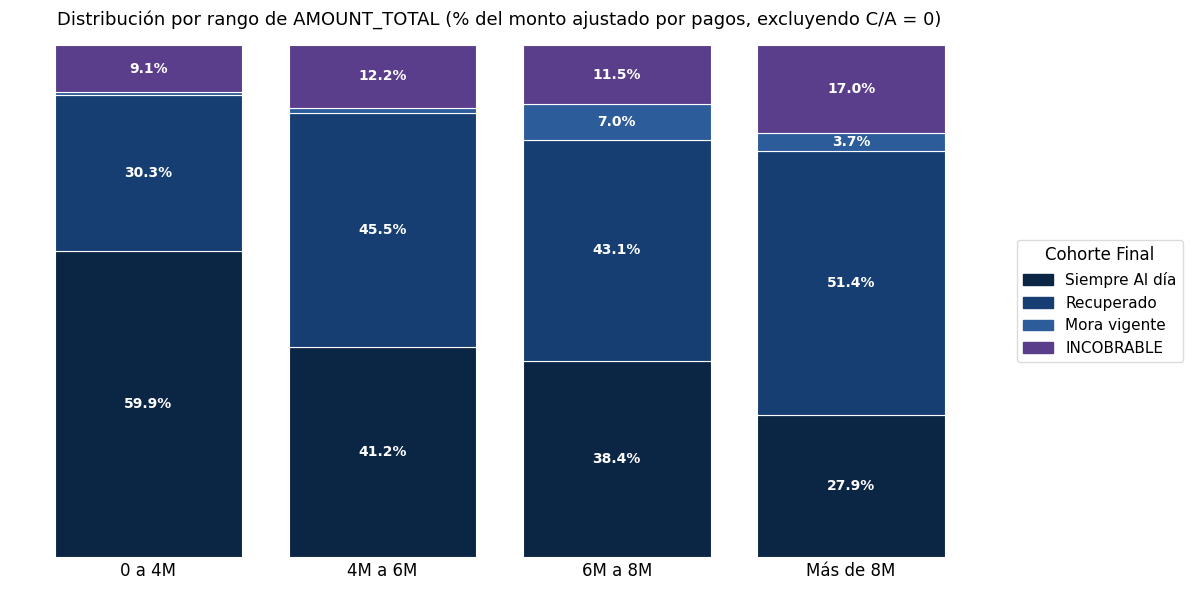

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# =====================
# 1) Cargar y filtrar
# =====================
df = dfw.copy()

# Excluir C/A == 0 (robusto si viene como str o num)
ca_num = pd.to_numeric(df["C/A"], errors="coerce")
df = df[ca_num != 0].copy()

# Asegurar numéricos
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce").fillna(0.0)
df["PAGO"] = pd.to_numeric(df["PAGO"], errors="coerce").fillna(0.0)

# =====================
# 2) Definir rangos y cohortes
# =====================
bins = [0, 4_000_000, 6_000_000, 8_000_000, float('inf')]
labels = ["0 a 4M", "4M a 6M", "6M a 8M", "Más de 8M"]

orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# Rango por AMOUNT_TOTAL (mismo criterio que tu ejemplo)
df["Rango_Monto"] = pd.cut(
    df["AMOUNT_TOTAL"], bins=bins, labels=labels,
    right=False, include_lowest=True, ordered=True
)

# Cohorte categórica ordenada
df["COHORTE_FINAL"] = pd.Categorical(
    df["COHORTE_FINAL"], categories=orden_cohortes, ordered=True
)

# =====================
# 3) MONTO_AJUSTADO con tu regla:
#    - Si cohorte es INCOBRABLE o Mora vigente:
#        PAGO → Recuperado ; (AMOUNT_TOTAL - PAGO_cap) → cohorte original
#    - Demás cohortes: todo AMOUNT_TOTAL queda en su cohorte
# =====================
ajustados = []
for _, row in df.iterrows():
    coh = row["COHORTE_FINAL"]
    total = row["AMOUNT_TOTAL"]
    pago_cap = min(row["PAGO"], total)

    if coh in ["INCOBRABLE", "Mora vigente"]:
        # Parte que se reclasifica a Recuperado
        if pago_cap > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": "Recuperado",
                "MONTO_AJUSTADO": pago_cap
            })
        # Resto que permanece en cohorte original
        restante = total - pago_cap
        if restante > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": restante
            })
    else:
        if total > 0:
            ajustados.append({
                "Rango_Monto": row["Rango_Monto"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": total
            })

df_adj = pd.DataFrame(ajustados)

# =====================
# 4) Tabla de % por Rango (X) y Cohorte (apilado), ponderado por MONTO_AJUSTADO
# =====================
tabla = (
    df_adj.groupby(["Rango_Monto", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
          .sum().reset_index(name="Monto")
)

# Asegurar todas las combinaciones para que no falte ningún segmento
full_index = pd.MultiIndex.from_product([labels, orden_cohortes],
                                        names=["Rango_Monto", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Monto", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0.0)
              .reset_index())

# % dentro de cada rango (suma 100% por barra)
tot_rango = tabla.groupby("Rango_Monto")["Monto"].transform("sum").replace(0, np.nan)
tabla["Porcentaje"] = ((tabla["Monto"] / tot_rango) * 100).fillna(0.0)

# Pivot a formato ancho: filas = rangos, columnas = cohortes, valores = %
pct = (
    tabla.pivot(index="Rango_Monto", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=labels, columns=orden_cohortes)
         .fillna(0.0)
)

# =====================
# 5) Gráfico minimalista estilo Matplotlib
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh],
           edgecolor='white', linewidth=0.8)
    # Etiquetas dentro de la barra (solo si el segmento >= 3%)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# Estilo limpio (sin eje Y)
ax.set_xticks(x)
ax.set_xticklabels(pct.index, rotation=0, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top','right','left','bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# ==== LEYENDA EXPLÍCITA ====
handles = [
    mpatches.Patch(color=colores['Siempre Al día'], label='Siempre Al día'),
    mpatches.Patch(color=colores['Recuperado'],     label='Recuperado'),
    mpatches.Patch(color=colores['Mora vigente'],   label='Mora vigente'),
    mpatches.Patch(color=colores['INCOBRABLE'],     label='INCOBRABLE'),
]

# más espacio a la derecha para la leyenda
plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

plt.title("Distribución por rango de AMOUNT_TOTAL (% del monto ajustado por pagos, excluyendo C/A = 0)",
          fontsize=13, pad=15)

plt.tight_layout()
plt.show()

# (Opcional) Guardar imagen
# fig.savefig("distribucion_amount_ajustado_por_rango.png", dpi=150, bbox_inches="tight")

#pp Comisión

In [203]:
import pandas as pd
import plotly.express as px
import re

# --- Datos base ---
df = dfw.copy()

# --- Orden y colores de cohortes ---
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"], categories=cohort_order, ordered=True)

# --- Orden de categorías para Rango_Ratio_PP ---
# Si ya es categórica y ordenada, respetamos ese orden; si no, ordenamos por el límite inferior numérico detectado.
if pd.api.types.is_categorical_dtype(df["Rango_Ratio_PP"]) and df["Rango_Ratio_PP"].cat.ordered:
    rango_order = list(df["Rango_Ratio_PP"].cat.categories)
else:
    def _key(s):
        s = str(s)
        m = re.search(r'(\d+(\.\d+)?)', s)  # toma el primer número (p.ej. 0 en "0-20%")
        return float(m.group(1)) if m else float('inf')
    rango_order = sorted(df["Rango_Ratio_PP"].dropna().astype(str).unique(), key=_key)

# ==========================
# 1) % de casos por Rango_Ratio_PP (X) y Cohorte (apilado)
# ==========================
tabla = (
    df.groupby(["Rango_Ratio_PP", "COHORTE_FINAL"], observed=True)
      .size()
      .reset_index(name="Conteo")
)

# Asegurar que existan todas las combinaciones rango×cohorte (evita huecos en barras)
full_index = pd.MultiIndex.from_product([rango_order, cohort_order],
                                        names=["Rango_Ratio_PP", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Ratio_PP", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# % dentro de cada rango (suma 100% por barra)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("Rango_Ratio_PP")["Conteo"].transform("sum") * 100
).fillna(0)

fig = px.bar(
    tabla,
    x="Rango_Ratio_PP",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"Rango_Ratio_PP": rango_order, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución por Rango_Ratio_PP (en % de casos) y Cohorte",
    text="Porcentaje"
)
fig.update_layout(
    barmode="stack",
    yaxis_title="Porcentaje de casos",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig.show()

# ==========================
# 2) Cantidad de casos por Rango_Ratio_PP (X)
# ==========================
conteo_rango = (
    df.groupby("Rango_Ratio_PP", observed=True)
      .size()
      .reindex(rango_order, fill_value=0)
      .reset_index(name="Casos")
)

fig2 = px.bar(
    conteo_rango,
    x="Rango_Ratio_PP",
    y="Casos",
    title="Cantidad de casos por Rango_Ratio_PP",
    text="Casos",
    category_orders={"Rango_Ratio_PP": rango_order}
)
fig2.update_layout(
    yaxis_title="Número de casos",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    template="plotly_white"
)
fig2.update_traces(textposition="outside")
fig2.show()

/tmp/ipython-input-2324199934.py:20: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



In [204]:
import pandas as pd
import plotly.express as px
import re

# --- Datos base ---
df = dfw.copy()

# 🔹 Filtrar: eliminar los casos donde C/A == 0
df = df[df["C/A"] != '0']

# --- Orden y colores de cohortes ---
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"], categories=cohort_order, ordered=True)

# --- Orden de categorías para Rango_Ratio_PP ---
if pd.api.types.is_categorical_dtype(df["Rango_Ratio_PP"]) and df["Rango_Ratio_PP"].cat.ordered:
    rango_order = list(df["Rango_Ratio_PP"].cat.categories)
else:
    def _key(s):
        s = str(s)
        m = re.search(r'(\d+(\.\d+)?)', s)
        return float(m.group(1)) if m else float('inf')
    rango_order = sorted(df["Rango_Ratio_PP"].dropna().astype(str).unique(), key=_key)

# ==========================
# 1) % de casos por Rango_Ratio_PP (X) y Cohorte (apilado)
# ==========================
tabla = (
    df.groupby(["Rango_Ratio_PP", "COHORTE_FINAL"], observed=True)
      .size()
      .reset_index(name="Conteo")
)

# Asegurar todas las combinaciones rango×cohorte
full_index = pd.MultiIndex.from_product([rango_order, cohort_order],
                                        names=["Rango_Ratio_PP", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Ratio_PP", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# % dentro de cada rango
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("Rango_Ratio_PP")["Conteo"].transform("sum") * 100
).fillna(0)

fig = px.bar(
    tabla,
    x="Rango_Ratio_PP",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"Rango_Ratio_PP": rango_order, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución por Rango_Ratio_PP (en % de casos, excluyendo C/A = 0)",
    text="Porcentaje"
)
fig.update_layout(
    barmode="stack",
    yaxis_title="Porcentaje de casos",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig.show()

# ==========================
# 2) Cantidad de casos por Rango_Ratio_PP (X)
# ==========================
conteo_rango = (
    df.groupby("Rango_Ratio_PP", observed=True)
      .size()
      .reindex(rango_order, fill_value=0)
      .reset_index(name="Casos")
)

fig2 = px.bar(
    conteo_rango,
    x="Rango_Ratio_PP",
    y="Casos",
    title="Cantidad de casos por Rango_Ratio_PP (excluyendo C/A = 0)",
    text="Casos",
    category_orders={"Rango_Ratio_PP": rango_order}
)
fig2.update_layout(
    yaxis_title="Número de casos",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    template="plotly_white"
)
fig2.update_traces(textposition="outside")
fig2.show()

/tmp/ipython-input-1789387644.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



/tmp/ipython-input-3074632375.py:32: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



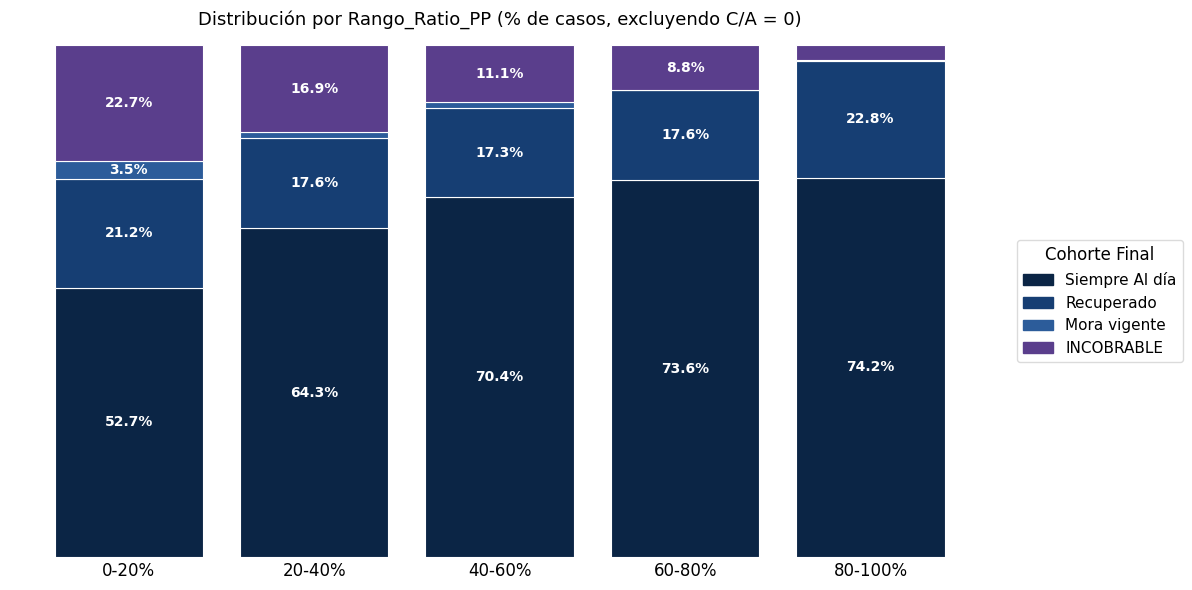

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# =====================
# 1) Cargar datos
# =====================
df = dfw.copy()

# =====================
# 2) Filtrar y preparar
# =====================
# 🔹 Excluir los casos con C/A = 0
df = df[df["C/A"] != 0]

# 🔹 Definir orden de cohortes y colores
orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}

# 🔹 Asegurar orden de cohortes
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"],
                                     categories=orden_cohortes, ordered=True)

# 🔹 Definir orden de los rangos de Rango_Ratio_PP
if pd.api.types.is_categorical_dtype(df["Rango_Ratio_PP"]) and df["Rango_Ratio_PP"].cat.ordered:
    rango_order = list(df["Rango_Ratio_PP"].cat.categories)
else:
    # Si no está ordenado, tratamos de ordenar según el primer número encontrado en el texto
    def _key(s):
        s = str(s)
        m = re.search(r'(\d+(\.\d+)?)', s)
        return float(m.group(1)) if m else float('inf')
    rango_order = sorted(df["Rango_Ratio_PP"].dropna().astype(str).unique(), key=_key)

# =====================
# 3) Tabla de % por rango y cohorte
# =====================
tabla = (
    df.groupby(["Rango_Ratio_PP", "COHORTE_FINAL"], observed=True)
      .size().reset_index(name="Conteo")
)

# Asegurar todas las combinaciones (para no dejar huecos)
full_index = pd.MultiIndex.from_product([rango_order, orden_cohortes],
                                        names=["Rango_Ratio_PP", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Ratio_PP", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# Calcular porcentaje dentro de cada rango (suma = 100%)
tabla["Porcentaje"] = (
    tabla["Conteo"] / tabla.groupby("Rango_Ratio_PP")["Conteo"].transform("sum") * 100
).fillna(0)

# Pivot a formato ancho
pct = (
    tabla.pivot(index="Rango_Ratio_PP", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=rango_order, columns=orden_cohortes)
         .fillna(0)
)

# =====================
# 4) Gráfico estilo minimalista Matplotlib
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh],
           edgecolor='white', linewidth=0.8)
    # Etiquetas dentro de cada barra (solo si el segmento >= 3%)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# ==== Estilo limpio ====
ax.set_xticks(x)
ax.set_xticklabels(pct.index, rotation=0, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# ==== Leyenda explícita ====
handles = [
    mpatches.Patch(color=colores['Siempre Al día'], label='Siempre Al día'),
    mpatches.Patch(color=colores['Recuperado'],     label='Recuperado'),
    mpatches.Patch(color=colores['Mora vigente'],   label='Mora vigente'),
    mpatches.Patch(color=colores['INCOBRABLE'],     label='INCOBRABLE'),
]

plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

# ==== Título general ====
plt.title("Distribución por Rango_Ratio_PP (% de casos, excluyendo C/A = 0)",
          fontsize=13, pad=15)

plt.tight_layout()
plt.show()

# (Opcional) Guardar imagen
# fig.savefig("distribucion_ratio_pp_por_cohorte.png", dpi=150, bbox_inches="tight")

In [206]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

# ==========================
# Helpers
# ==========================
def ordenar_rangos_textuales(series):
    """Ordena categorías tipo '0-20%', '20-40%', '80-100%' por su límite inferior."""
    if pd.api.types.is_categorical_dtype(series) and series.cat.ordered:
        return list(series.cat.categories)
    vals = series.dropna().astype(str).unique()
    def _key(s):
        m = re.search(r'(\d+(\.\d+)?)', s)
        return float(m.group(1)) if m else float('inf')
    return sorted(vals, key=_key)

def split_amount_by_payment(df,
                            cohort_col='COHORTE_FINAL',
                            amount_col='AMOUNT_TOTAL',
                            pago_col='PAGO',
                            cohorts_to_split=('INCOBRABLE', 'Mora vigente'),
                            recuperado_label='Recuperado'):
    """
    Para cohortes en cohorts_to_split:
      - Crea 2 filas:
        a) monto_recup = min(PAGO, AMOUNT_TOTAL) con cohorte = 'Recuperado'
        b) monto_rest  = AMOUNT_TOTAL - monto_recup con cohorte = cohorte original
    Para las demás cohortes:
      - Mantiene AMOUNT_TOTAL en su cohorte original.
    Devuelve el DF con una columna 'MONTO_AJUSTADO' lista para agregaciones.
    """
    dff = df.copy()

    # Asegurar numéricos
    dff[amount_col] = pd.to_numeric(dff[amount_col], errors='coerce').fillna(0.0)
    dff[pago_col]   = pd.to_numeric(dff[pago_col], errors='coerce').fillna(0.0)

    # Filas que se dividen
    mask = dff[cohort_col].isin(cohorts_to_split)
    if mask.any():
        pago_cap = np.clip(dff.loc[mask, pago_col].values, 0.0, dff.loc[mask, amount_col].values)
        monto_rest = dff.loc[mask, amount_col].values - pago_cap

        # Parte Recuperado
        df_recup = dff.loc[mask].copy()
        df_recup[cohort_col] = recuperado_label
        df_recup["MONTO_AJUSTADO"] = pago_cap
        df_recup = df_recup[df_recup["MONTO_AJUSTADO"] > 0]

        # Parte que permanece en cohorte original
        df_rest = dff.loc[mask].copy()
        df_rest["MONTO_AJUSTADO"] = monto_rest
        df_rest = df_rest[df_rest["MONTO_AJUSTADO"] > 0]

        # Filas que NO se dividen (otras cohortes): todo el AMOUNT_TOTAL
        df_keep = dff.loc[~mask].copy()
        df_keep["MONTO_AJUSTADO"] = df_keep[amount_col]
        df_keep = df_keep[df_keep["MONTO_AJUSTADO"] > 0]

        out = pd.concat([df_keep, df_rest, df_recup], ignore_index=True)
    else:
        # Nadie se divide; todo el AMOUNT_TOTAL pasa tal cual
        dff["MONTO_AJUSTADO"] = dff[amount_col]
        out = dff[dff["MONTO_AJUSTADO"] > 0].copy()

    return out

# ==========================
# 1) Base y filtros
# ==========================
df = dfw.copy()

# Excluir C/A == 0 (robusto a tipo numérico o texto)
ca_num = pd.to_numeric(df["C/A"], errors="coerce")
df = df[ca_num != 0]

# Cohortes y colores
cohort_order = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
color_map = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"], categories=cohort_order, ordered=True)

# Orden de rangos para Rango_Ratio_PP
rango_order = ordenar_rangos_textuales(df["Rango_Ratio_PP"])

# ==========================
# 2) Construir MONTO_AJUSTADO según tu regla (PAGO -> Recuperado, RESTO -> cohorte original)
# ==========================
cols_needed = ["Rango_Ratio_PP", "COHORTE_FINAL", "AMOUNT_TOTAL", "PAGO"]
dff = df[cols_needed].copy()
dff_adj = split_amount_by_payment(
    dff,
    cohort_col='COHORTE_FINAL',
    amount_col='AMOUNT_TOTAL',
    pago_col='PAGO',
    cohorts_to_split=('INCOBRABLE', 'Mora vigente'),
    recuperado_label='Recuperado'
)

# ==========================
# 3) % por rango (ponderado por MONTO_AJUSTADO)
# ==========================
tabla = (
    dff_adj.groupby(["Rango_Ratio_PP", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
           .sum()
           .reset_index(name="Monto")
)

# asegurar todas las combinaciones rango×cohorte
full_index = pd.MultiIndex.from_product([rango_order, cohort_order],
                                        names=["Rango_Ratio_PP", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Ratio_PP", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0.0)
              .reset_index())

# porcentaje dentro de cada rango (suma 100% por barra)
tot_rango = tabla.groupby("Rango_Ratio_PP")["Monto"].transform("sum").replace(0, np.nan)
tabla["Porcentaje"] = ((tabla["Monto"] / tot_rango) * 100).fillna(0.0)

# ==========================
# 4) GRÁFICO 1 — Barras apiladas 100% por MONTO_AJUSTADO
# ==========================
fig = px.bar(
    tabla,
    x="Rango_Ratio_PP",
    y="Porcentaje",
    color="COHORTE_FINAL",
    category_orders={"Rango_Ratio_PP": rango_order, "COHORTE_FINAL": cohort_order},
    color_discrete_map=color_map,
    title="Distribución por Rango_Ratio_PP (en % del MONTO ajustado por pagos, excluyendo C/A = 0)",
    text="Porcentaje"
)
fig.update_layout(
    barmode="stack",
    yaxis_title="Porcentaje del MONTO (ajustado)",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    legend_title="Cohorte",
    template="plotly_white",
    yaxis=dict(range=[0, 100])
)
fig.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
fig.show()

# ==========================
# 5) GRÁFICO 2 — MONTO_AJUSTADO total por rango
# ==========================
monto_rango = (
    dff_adj.groupby("Rango_Ratio_PP", observed=True)["MONTO_AJUSTADO"]
           .sum()
           .reindex(rango_order, fill_value=0.0)
           .reset_index(name="Monto_Ajustado_Total")
)

fig2 = px.bar(
    monto_rango,
    x="Rango_Ratio_PP",
    y="Monto_Ajustado_Total",
    title="Monto ajustado total por Rango_Ratio_PP (excluyendo C/A = 0)",
    text="Monto_Ajustado_Total",
    category_orders={"Rango_Ratio_PP": rango_order}
)
fig2.update_layout(
    yaxis_title="Monto ajustado",
    xaxis_title="Rangos de Ratio_PP (PP_Comision / AMOUNT_TOTAL)",
    template="plotly_white"
)
fig2.update_traces(texttemplate="%{text:,.0f}", textposition="outside")
fig2.show()

/tmp/ipython-input-3594285762.py:11: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



/tmp/ipython-input-2808872747.py:28: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



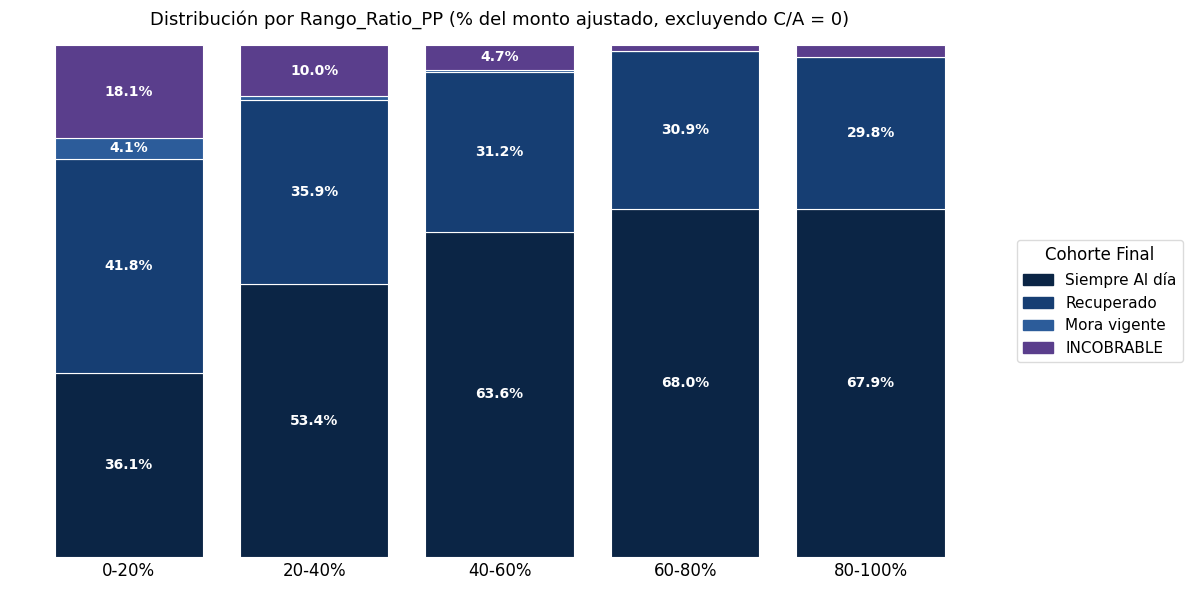

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# =====================
# 1) Copiar y filtrar
# =====================
df = dfw.copy()
df = df[df["C/A"] != 0]

# =====================
# 2) Definir colores y orden
# =====================
orden_cohortes = ["Siempre Al día", "Recuperado", "Mora vigente", "INCOBRABLE"]
colores = {
    "Siempre Al día": "#0B2545",
    "Recuperado":     "#163E73",
    "Mora vigente":   "#2C5C9A",
    "INCOBRABLE":     "#5A3E8C",
}
df["COHORTE_FINAL"] = pd.Categorical(df["COHORTE_FINAL"], categories=orden_cohortes, ordered=True)

# =====================
# 3) Ordenar rangos (por número)
# =====================
if pd.api.types.is_categorical_dtype(df["Rango_Ratio_PP"]) and df["Rango_Ratio_PP"].cat.ordered:
    rango_order = list(df["Rango_Ratio_PP"].cat.categories)
else:
    def _key(s):
        s = str(s)
        m = re.search(r'(\d+(\.\d+)?)', s)
        return float(m.group(1)) if m else float('inf')
    rango_order = sorted(df["Rango_Ratio_PP"].dropna().astype(str).unique(), key=_key)

# =====================
# 4) Calcular MONTO_AJUSTADO (según tu lógica)
# =====================
df["PAGO"] = pd.to_numeric(df["PAGO"], errors="coerce").fillna(0)
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce").fillna(0)

ajustados = []
for _, row in df.iterrows():
    coh = row["COHORTE_FINAL"]
    pago = min(row["PAGO"], row["AMOUNT_TOTAL"])
    total = row["AMOUNT_TOTAL"]

    # Cohortes especiales: dividir en dos partes
    if coh in ["INCOBRABLE", "Mora vigente"]:
        # Parte recuperada
        if pago > 0:
            ajustados.append({
                "Rango_Ratio_PP": row["Rango_Ratio_PP"],
                "COHORTE_FINAL": "Recuperado",
                "MONTO_AJUSTADO": pago
            })
        # Parte restante
        restante = total - pago
        if restante > 0:
            ajustados.append({
                "Rango_Ratio_PP": row["Rango_Ratio_PP"],
                "COHORTE_FINAL": coh,
                "MONTO_AJUSTADO": restante
            })
    else:
        # Las demás cohortes no se dividen
        ajustados.append({
            "Rango_Ratio_PP": row["Rango_Ratio_PP"],
            "COHORTE_FINAL": coh,
            "MONTO_AJUSTADO": total
        })

df_adj = pd.DataFrame(ajustados)

# =====================
# 5) Tabla de % por rango y cohorte
# =====================
tabla = (
    df_adj.groupby(["Rango_Ratio_PP", "COHORTE_FINAL"], observed=True)["MONTO_AJUSTADO"]
          .sum().reset_index(name="Monto")
)

# Asegurar todas las combinaciones (rango × cohorte)
full_index = pd.MultiIndex.from_product([rango_order, orden_cohortes],
                                        names=["Rango_Ratio_PP", "COHORTE_FINAL"])
tabla = (tabla.set_index(["Rango_Ratio_PP", "COHORTE_FINAL"])
              .reindex(full_index, fill_value=0)
              .reset_index())

# Porcentaje dentro de cada rango
tabla["Porcentaje"] = (
    tabla["Monto"] / tabla.groupby("Rango_Ratio_PP")["Monto"].transform("sum") * 100
).fillna(0)

# Pivot para graficar
pct = (
    tabla.pivot(index="Rango_Ratio_PP", columns="COHORTE_FINAL", values="Porcentaje")
         .reindex(index=rango_order, columns=orden_cohortes)
         .fillna(0)
)

# =====================
# 6) Gráfico Matplotlib estilo limpio
# =====================
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(pct))
x = np.arange(len(pct.index))

for coh in orden_cohortes:
    vals = pct[coh].values
    ax.bar(x, vals, bottom=bottom, color=colores[coh], edgecolor='white', linewidth=0.8)
    for i, (b, v) in enumerate(zip(bottom, vals)):
        if v >= 3:
            ax.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center',
                    color='white', fontsize=10, fontweight='bold')
    bottom += vals

# ===== Estilo =====
ax.set_xticks(x)
ax.set_xticklabels(pct.index, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([])
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# ===== Leyenda =====
handles = [mpatches.Patch(color=colores[c], label=c) for c in orden_cohortes]
plt.subplots_adjust(right=0.82)
leg = ax.legend(handles=handles, title='Cohorte Final',
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                frameon=True, edgecolor='lightgray',
                fontsize=11, title_fontsize=12)

# ===== Título =====
plt.title("Distribución por Rango_Ratio_PP (% del monto ajustado, excluyendo C/A = 0)",
          fontsize=13, pad=15)

plt.tight_layout()
plt.show()

In [208]:
# Crear un nuevo DataFrame con las columnas seleccionadas
df_prediccion = dfw[["REFERENCIA", "COHORTE_FINAL", "AMOUNT_TOTAL", "PAGO", "PRI-ULT", "Ratio_PP", "C/A"]].copy()
df_prediccion

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A
0,1001082965,Recuperado,6.897798e+05,689780.0,2,0.852787,0.04922800754
1,1001082965,Recuperado,4.778597e+05,477860.0,1,1.000000,0
2,1001082965,INCOBRABLE,1.647020e+06,624732.0,5,0.306640,1.005446711
3,1001244516,Siempre Al día,9.799874e+05,979988.0,6,0.185378,1.823532276
4,1001833139,Siempre Al día,3.096815e+05,976050.0,2,0.321611,1.454545468
...,...,...,...,...,...,...,...
4475,9734026,Siempre Al día,2.342403e+05,234240.0,1,0.999999,0
4476,98501254,Recuperado,3.418597e+05,341860.0,2,1.000000,0.2626919868
4477,98702966,Recuperado,1.979920e+06,1979921.0,6,0.100165,0.8976457693
4478,98702966,Mora vigente,1.533134e+07,6078401.0,17,0.087918,1.144751985


In [209]:
df_prediccion['recaudo_real'] = df_prediccion['PAGO'] / df_prediccion['AMOUNT_TOTAL']

In [210]:
df_prediccion['recaudo_real'] = np.where(df_prediccion['recaudo_real'] > 1, 1, df_prediccion['recaudo_real'])

In [211]:
df_prediccion

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A,recaudo_real
0,1001082965,Recuperado,6.897798e+05,689780.0,2,0.852787,0.04922800754,1.000000
1,1001082965,Recuperado,4.778597e+05,477860.0,1,1.000000,0,1.000000
2,1001082965,INCOBRABLE,1.647020e+06,624732.0,5,0.306640,1.005446711,0.379310
3,1001244516,Siempre Al día,9.799874e+05,979988.0,6,0.185378,1.823532276,1.000000
4,1001833139,Siempre Al día,3.096815e+05,976050.0,2,0.321611,1.454545468,1.000000
...,...,...,...,...,...,...,...,...
4475,9734026,Siempre Al día,2.342403e+05,234240.0,1,0.999999,0,0.999999
4476,98501254,Recuperado,3.418597e+05,341860.0,2,1.000000,0.2626919868,1.000000
4477,98702966,Recuperado,1.979920e+06,1979921.0,6,0.100165,0.8976457693,1.000000
4478,98702966,Mora vigente,1.533134e+07,6078401.0,17,0.087918,1.144751985,0.396469


In [212]:
import os, json, re
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe

SHEET_URL = "https://docs.google.com/spreadsheets/d/1xGSzneJkRqREZupLshG9jaNK8wbP8WpV-yjUs_Lm7AA"
TARGET_SHEET = "ORGINACIONES_UNICAS"

def _load_creds():
    # 1) Colab secret
    try:
        from google.colab import userdata  # type: ignore
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            return Credentials.from_service_account_info(
                json.loads(mi_json),
                scopes=["https://www.googleapis.com/auth/spreadsheets","https://www.googleapis.com/auth/drive"]
            )
    except Exception:
        pass
    # 2) Env var (GitHub/local)
    mi_json = os.environ.get("MI_JSON")
    if mi_json:
        return Credentials.from_service_account_info(
            json.loads(mi_json),
            scopes=["https://www.googleapis.com/auth/spreadsheets","https://www.googleapis.com/auth/drive"]
        )
    # 3) Archivo local
    if os.path.exists("service_account.json"):
        with open("service_account.json", "r", encoding="utf-8") as f:
            info = json.load(f)
        return Credentials.from_service_account_info(
            info,
            scopes=["https://www.googleapis.com/auth/spreadsheets","https://www.googleapis.com/auth/drive"]
        )
    raise RuntimeError("No encontré credenciales MI_JSON.")

def _parse_sheet_url(url_or_id: str):
    if "/d/" in url_or_id:
        spreadsheet_id = url_or_id.split("/d/")[1].split("/")[0]
    else:
        spreadsheet_id = url_or_id
    return spreadsheet_id

def upload_df(df: pd.DataFrame, spreadsheet_url_or_id: str, sheet_name: str, mode: str = "replace"):
    creds = _load_creds()
    gc = gspread.authorize(creds)
    sh = gc.open_by_key(_parse_sheet_url(spreadsheet_url_or_id))

    # (Opcional) compartir con tu correo humano (si existe CORREO_COLAB)
    correo_colab = None
    try:
        from google.colab import userdata  # type: ignore
        correo_colab = userdata.get("CORREO_COLAB")
    except Exception:
        correo_colab = os.environ.get("CORREO_COLAB")

    if correo_colab:
        try:
            sh.share(correo_colab, perm_type="user", role="writer", notify=False)
        except Exception:
            pass  # si ya está compartido, ignora

    # resolver worksheet
    try:
        ws = sh.worksheet(sheet_name)
    except gspread.exceptions.WorksheetNotFound:
        ws = sh.add_worksheet(title=sheet_name, rows="100", cols="26")

    if mode == "append":
        values = ws.get_all_values()
        start_row = len(values) + 1 if values else 1
        if not values:
            set_with_dataframe(ws, df, row=1, col=1, include_index=False, include_column_header=True, resize=True)
        else:
            set_with_dataframe(ws, df, row=start_row, col=1, include_index=False, include_column_header=False, resize=True)
    else:
        ws.clear()
        set_with_dataframe(ws, df, include_index=False, include_column_header=True, resize=True)

    print("✅ Subido a hoja:", sheet_name)

# --- usa df_prediccion ---
upload_df(df_prediccion, SHEET_URL, TARGET_SHEET, mode="replace")

✅ Subido a hoja: ORGINACIONES_UNICAS
